# Nuclear chromatin phenotypes of PBMCs reflects the treatment effect of proton therapy (Head & Neck cancers)

---
This notebook summarizes the analysis corresponding to the results presented in figure 4 of the paper for Head & Neck cancers patients. It can be used to rerun the analysis and regenerate the corresponding panels.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 300

import sys

sys.path.append("../..")
from src.utils.notebooks.eda import *
from src.utils.notebooks.figure3 import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, StratifiedGroupKFold

seed = 1234
random.seed(1234)
np.random.seed(1234)

%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
nuc_feature_desc = pd.read_csv(
    "../../data/chrometric_feature_description.csv", index_col=0
)
feature_name_dict = dict(
    zip(
        list(nuc_feature_desc.loc[:, "feature"]),
        list(nuc_feature_desc.loc[:, "long_name"]),
    )
)
feature_color_dict = {
    "morphology": "b",
    "intensity": "g",
    "boundary": "r",
    "texture": "c",
    "chromatin condensation": "m",
    "moments": "y",
    np.nan: "k",
}
feature_color_dict = {
    feature: feature_color_dict[category]
    for (feature, category) in zip(
        list(nuc_feature_desc.loc[:, "long_name"]),
        list(nuc_feature_desc.loc[:, "category"]),
    )
}

<IPython.core.display.Javascript object>

In [3]:
color_palette = {
    "prior": "plum",
    "during": "deeppink",
    "end": "indigo",
}

<IPython.core.display.Javascript object>

---

## 1. Read in data

In this notebook we assess the differences of the cell states of PBMCs at three different time points of the proton therapy treatment: before, during (~3 weeks in) and at the end of the treatment (final week of treatment). To this end, we obtained PBMCs of 8 Head & Neck cancer patients stained them for DNA, gH2AX and Lamin A/C and obtained fluorescent images.

First, we read in the required data set that describe each PBMCs by a number of hand-crafted features extracted from the fluorescent images of the cells.

In [4]:
tp1_root_data_dir = "../../data/headneck/proteins/timepoint_1"
feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"
gh2ax_foci_result_file_path = "/preprocessed/full_pipeline/gh2ax_foci_feats.csv"

<IPython.core.display.Javascript object>

In [5]:
tp1_data = read_in_protein_dataset(
    data_dir=tp1_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    gh2ax_foci_result_file_path=gh2ax_foci_result_file_path,
)
tp1_data["id"] = tp1_data["sample"] + tp1_data["timepoint"]
tp1_data["timepoint"] = "prior"
tp1_data["file_name"] = np.array(list(tp1_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 22.34it/s]


<IPython.core.display.Javascript object>

In [6]:
tp2_root_data_dir = "../../data/headneck/proteins/timepoint_2"

tp2_data = read_in_protein_dataset(
    data_dir=tp2_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    gh2ax_foci_result_file_path=gh2ax_foci_result_file_path,
)
tp2_data["id"] = tp2_data["sample"] + tp2_data["timepoint"]
tp2_data["timepoint"] = "during"
tp2_data["file_name"] = np.array(list(tp2_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 23.57it/s]


<IPython.core.display.Javascript object>

In [7]:
tp3_root_data_dir = "../../data/headneck/proteins/timepoint_3"

tp3_data = read_in_protein_dataset(
    data_dir=tp3_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    gh2ax_foci_result_file_path=gh2ax_foci_result_file_path,
)
tp3_data["id"] = tp3_data["sample"] + tp3_data["timepoint"]
tp3_data["timepoint"] = "end"
tp3_data["file_name"] = np.array(list(tp3_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 24.15it/s]


<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

Before we analyze the data, we will first preprocess it.

To this end, we first remove features with missing values and samples with missing features.

In [8]:
tp1_data = preprocess_data(tp1_data, remove_constant_features=False)
tp2_data = preprocess_data(tp2_data, remove_constant_features=False)
tp3_data = preprocess_data(tp3_data, remove_constant_features=False)

all_data = tp1_data.append(tp2_data).append(tp3_data)
all_data.index = all_data["id"] + "_" + all_data.index

Nuclei that did not pass the quality check: 399/5355. Remaining: 4956.
Removed 9 constant or features with missing values. Remaining: 295.
Removed additional 6 features. Remaining: 289.
Nuclei that did not pass the quality check: 348/5543. Remaining: 5195.
Removed 12 constant or features with missing values. Remaining: 292.
Removed additional 6 features. Remaining: 286.
Nuclei that did not pass the quality check: 68/4612. Remaining: 4544.
Removed 12 constant or features with missing values. Remaining: 292.
Removed additional 6 features. Remaining: 286.


<IPython.core.display.Javascript object>

In [9]:
all_data = all_data.rename(columns=feature_name_dict)

<IPython.core.display.Javascript object>

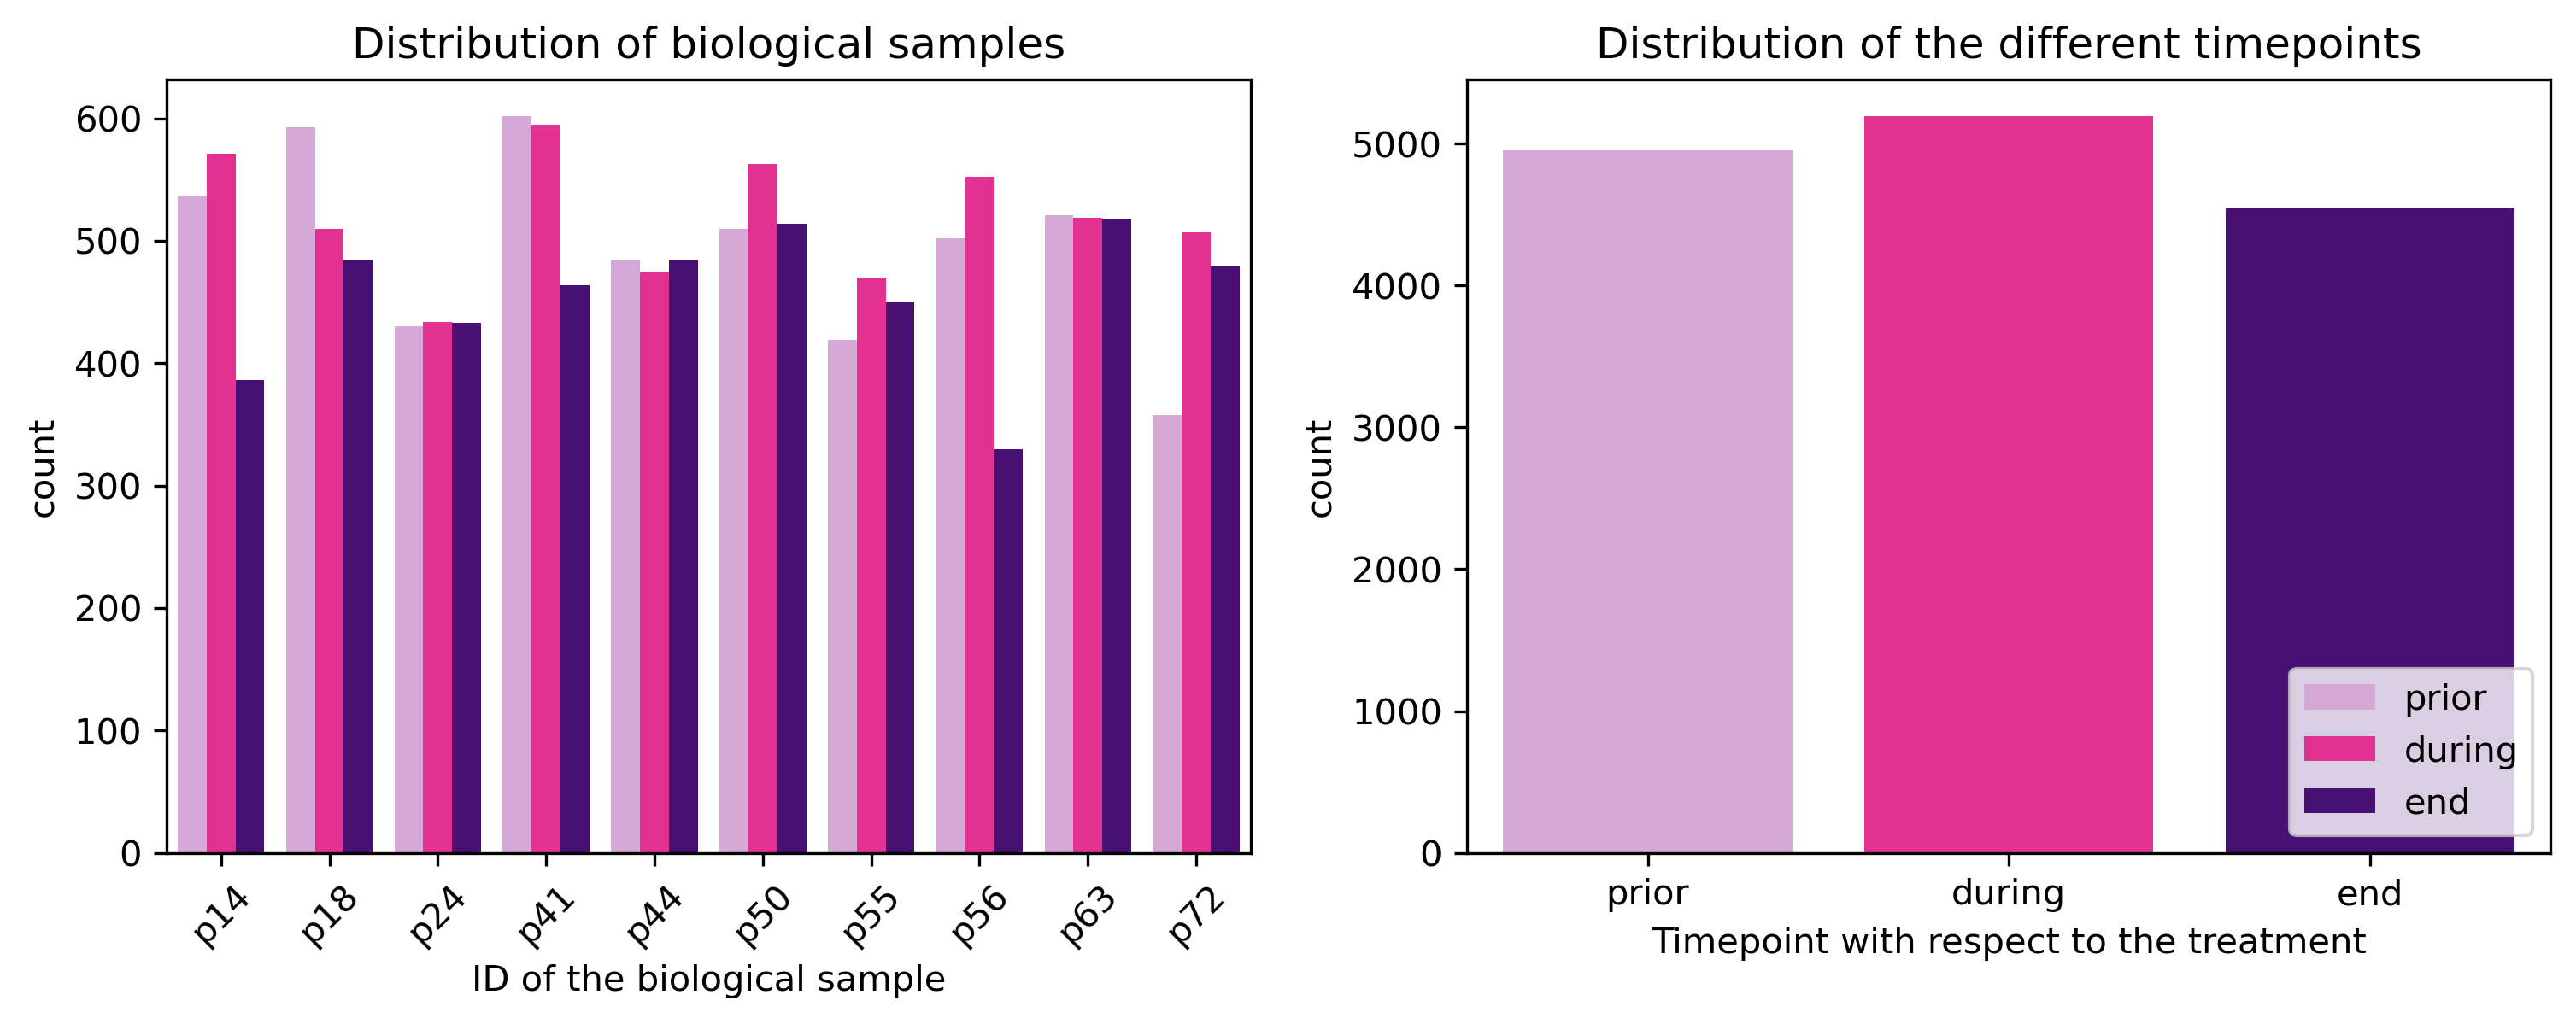

<IPython.core.display.Javascript object>

In [10]:
fig, ax = plt.subplots(figsize=[12, 4], ncols=2)
tp_order = ["prior", "during", "end"]
sample_order = np.unique(all_data.loc[:, "sample"])
ax = ax.flatten()
ax[0] = sns.countplot(
    x="sample",
    data=all_data,
    ax=ax[0],
    order=sample_order,
    hue_order=tp_order,
    hue="timepoint",
    palette=color_palette,
)
ax[0].legend([], [], frameon=False)
ax[0].set_xlabel("ID of the biological sample")
ax[0].set_title("Distribution of biological samples")
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

ax[1] = sns.countplot(
    x="timepoint",
    hue="timepoint",
    data=all_data,
    ax=ax[1],
    order=tp_order,
    dodge=False,
    palette=color_palette,
)
ax[1].set_xlabel("Timepoint with respect to the treatment")
ax[1].set_title("Distribution of the different timepoints")
ax[1].legend(loc="lower right")

plt.show()
plt.close()

___

#### Subsampling

We next subsample the data set such that for each timepoint we have the same number of nuclei in the data set. Additionally, we ensure that the individual timepoint population are approximately uniformly represented by the different biological (patient) samples.

In [11]:
sampled_data = get_stratified_data(
    all_data, id_column="id", cond_column="timepoint", seed=1234
)

<IPython.core.display.Javascript object>

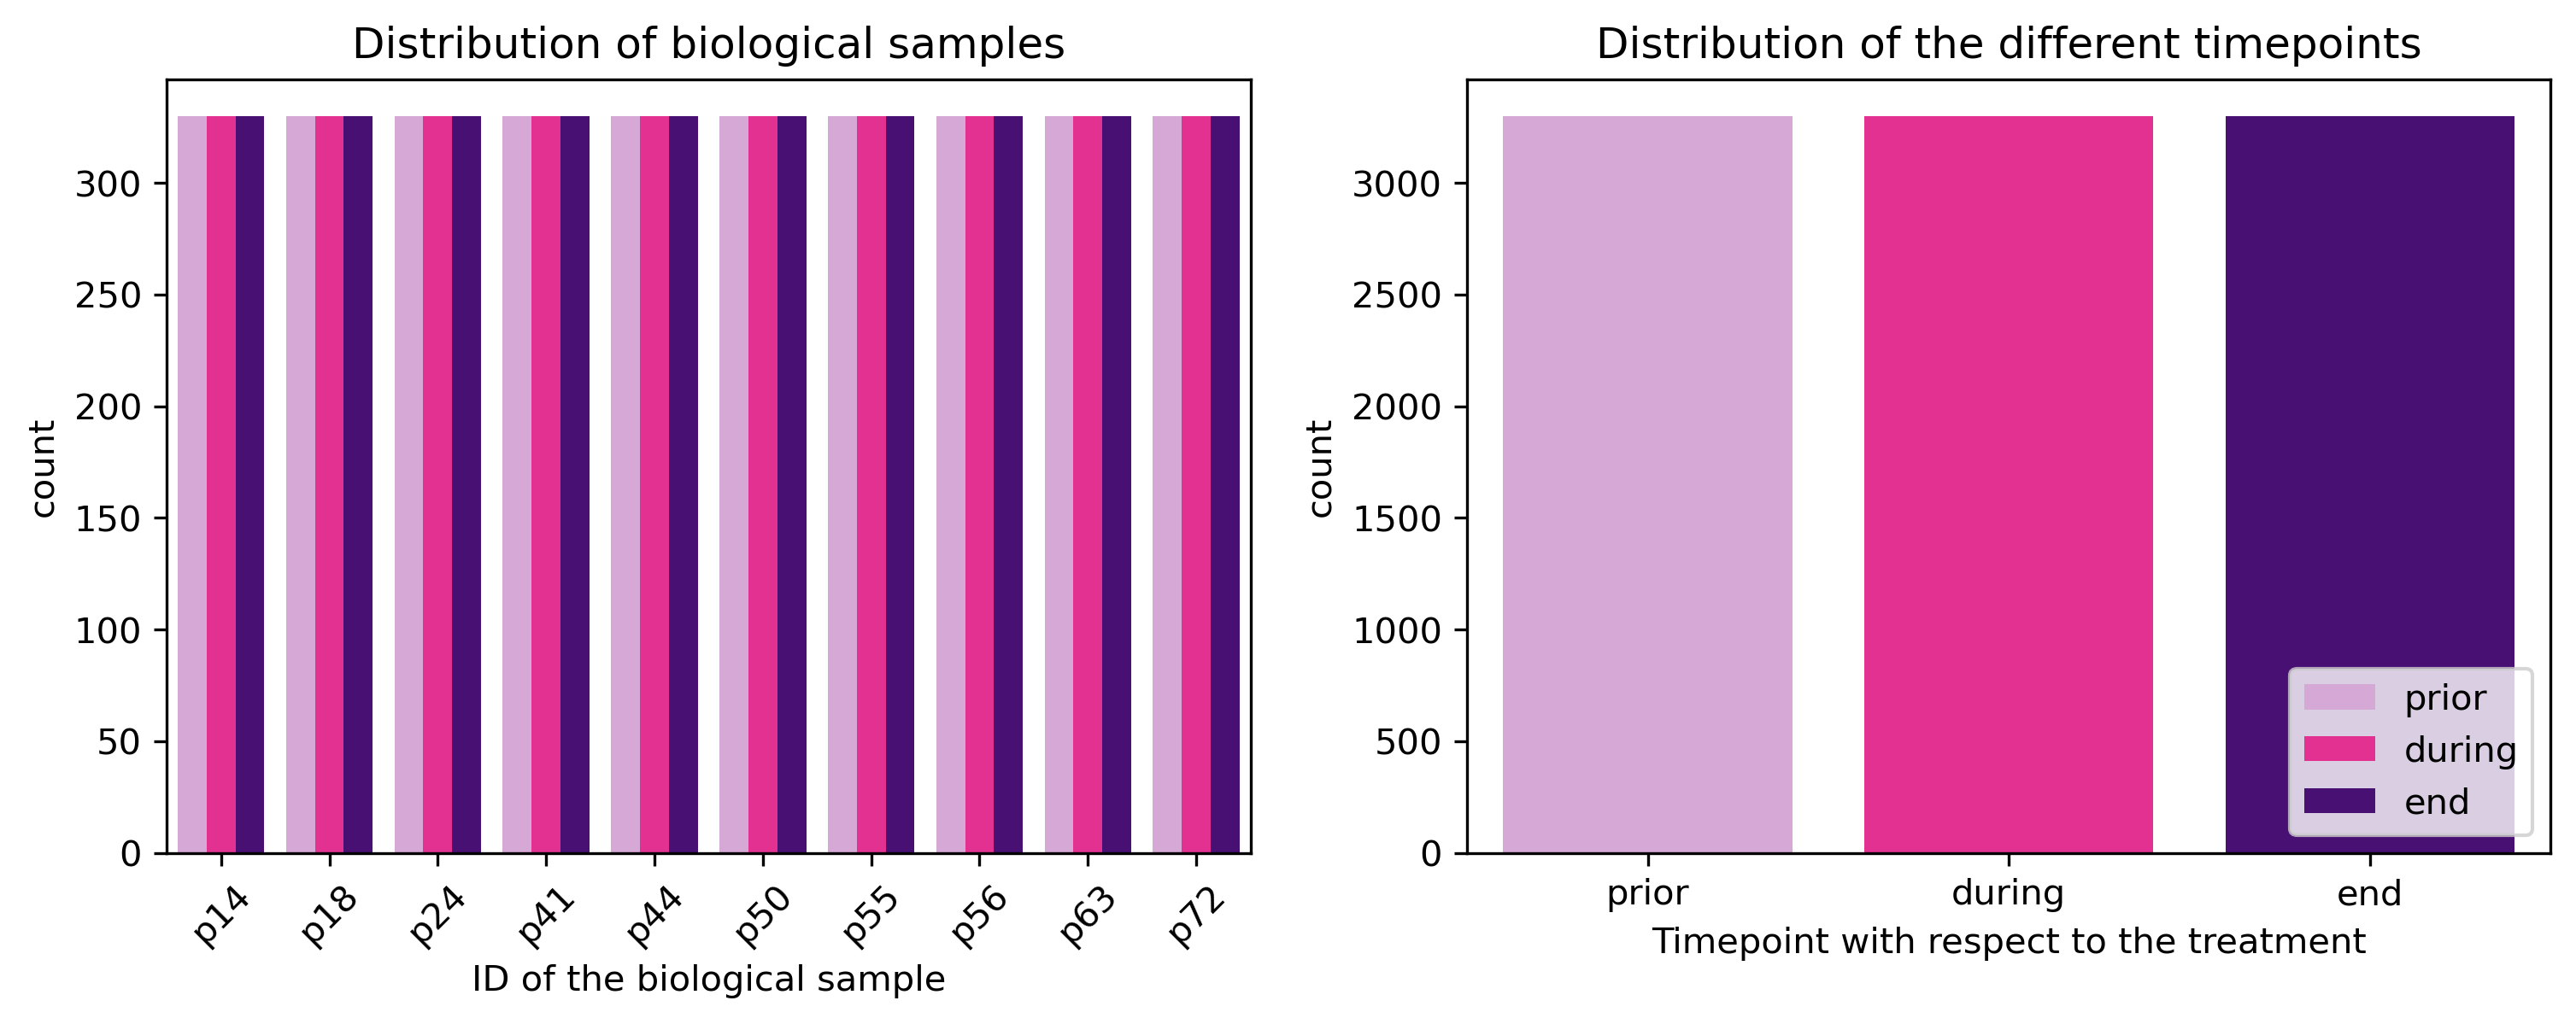

<IPython.core.display.Javascript object>

In [12]:
fig, ax = plt.subplots(figsize=[12, 4], ncols=2)
tp_order = ["prior", "during", "end"]
sample_order = np.unique(all_data.loc[:, "sample"])
ax = ax.flatten()
ax[0] = sns.countplot(
    x="sample",
    data=sampled_data,
    ax=ax[0],
    order=sample_order,
    hue_order=tp_order,
    hue="timepoint",
    palette=color_palette,
)
ax[0].legend([], [], frameon=False)
ax[0].set_xlabel("ID of the biological sample")
ax[0].set_title("Distribution of biological samples")
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

ax[1] = sns.countplot(
    x="timepoint",
    hue="timepoint",
    data=sampled_data,
    ax=ax[1],
    order=tp_order,
    hue_order=tp_order,
    dodge=False,
    palette=color_palette,
)
ax[1].set_xlabel("Timepoint with respect to the treatment")
ax[1].set_title("Distribution of the different timepoints")
ax[1].legend(loc="lower right")

plt.show()
plt.close()

----

#### Sample and feature selection

We now filter out constant features and nuclei with missing features.

In [13]:
data = preprocess_data(sampled_data, remove_constant_features=True)

Nuclei that did not pass the quality check: 0/9900. Remaining: 9900.
Removed 8 constant or features with missing values. Remaining: 281.
Removed additional 0 features. Remaining: 281.


<IPython.core.display.Javascript object>

---

#### Data preparation

After sampling the data, we will now prepare the data for the consecutive analysis, i.e. extracting only chrometric features and corresponding metadata information.

In [14]:
all_chrometric_data = get_chrometric_data(
    data,
    proteins=["gh2ax", "lamin", "cd3"],
    exclude_dna_int=True,
)

sample_labels = data.loc[:, "sample"]
tp_labels = data.loc[:, "timepoint"]

<IPython.core.display.Javascript object>

Finally, we remove highly correlated features (Pearson $\rho > 0.8$) from the chrometric features.

In [15]:
chrometric_data = remove_correlated_features(all_chrometric_data, threshold=0.8)

Removed 146/192 features with a Pearson correlation above 0.8. Remaining: 46


<IPython.core.display.Javascript object>

---

## 3. Panels

Now we generate the individual panels for figure 3 of the paper.


### 3a. Visualization of changes of nuclear phenotypes in different cancer types

First, we provide a visual representation of the different nuclear phenotypes in health and cancer. To this end, we will randomly sample 36 nuclei from each of the three cancer types and plot a corresponding montage of the max-z projected DNA images. To visualize size differences each nuclei is padded to a size of 150x150 pixels. Note that the nuclei images were obtained from range-normalized DAPI images. The range normalization was used to mitigate batch effects.

In [16]:
image_file_path = "preprocessed/full_pipeline/segmentation/nuclei_images"
sampled_tp1_images = get_random_images(
    data.loc[data.timepoint == "prior"],
    image_file_path,
    data_dir_col="data_dir",
    n_images=36,
    seed=1234,
    file_ending=".tif",
    file_name_col="file_name",
)

sampled_tp2_images = get_random_images(
    data.loc[data.timepoint == "during"],
    image_file_path,
    data_dir_col="data_dir",
    n_images=36,
    seed=1234,
    file_ending=".tif",
    file_name_col="file_name",
)

sampled_tp3_images = get_random_images(
    data.loc[data.timepoint == "end"],
    image_file_path,
    data_dir_col="data_dir",
    n_images=36,
    seed=1234,
    file_ending=".tif",
    file_name_col="file_name",
)

<IPython.core.display.Javascript object>

#### Prior treatment population

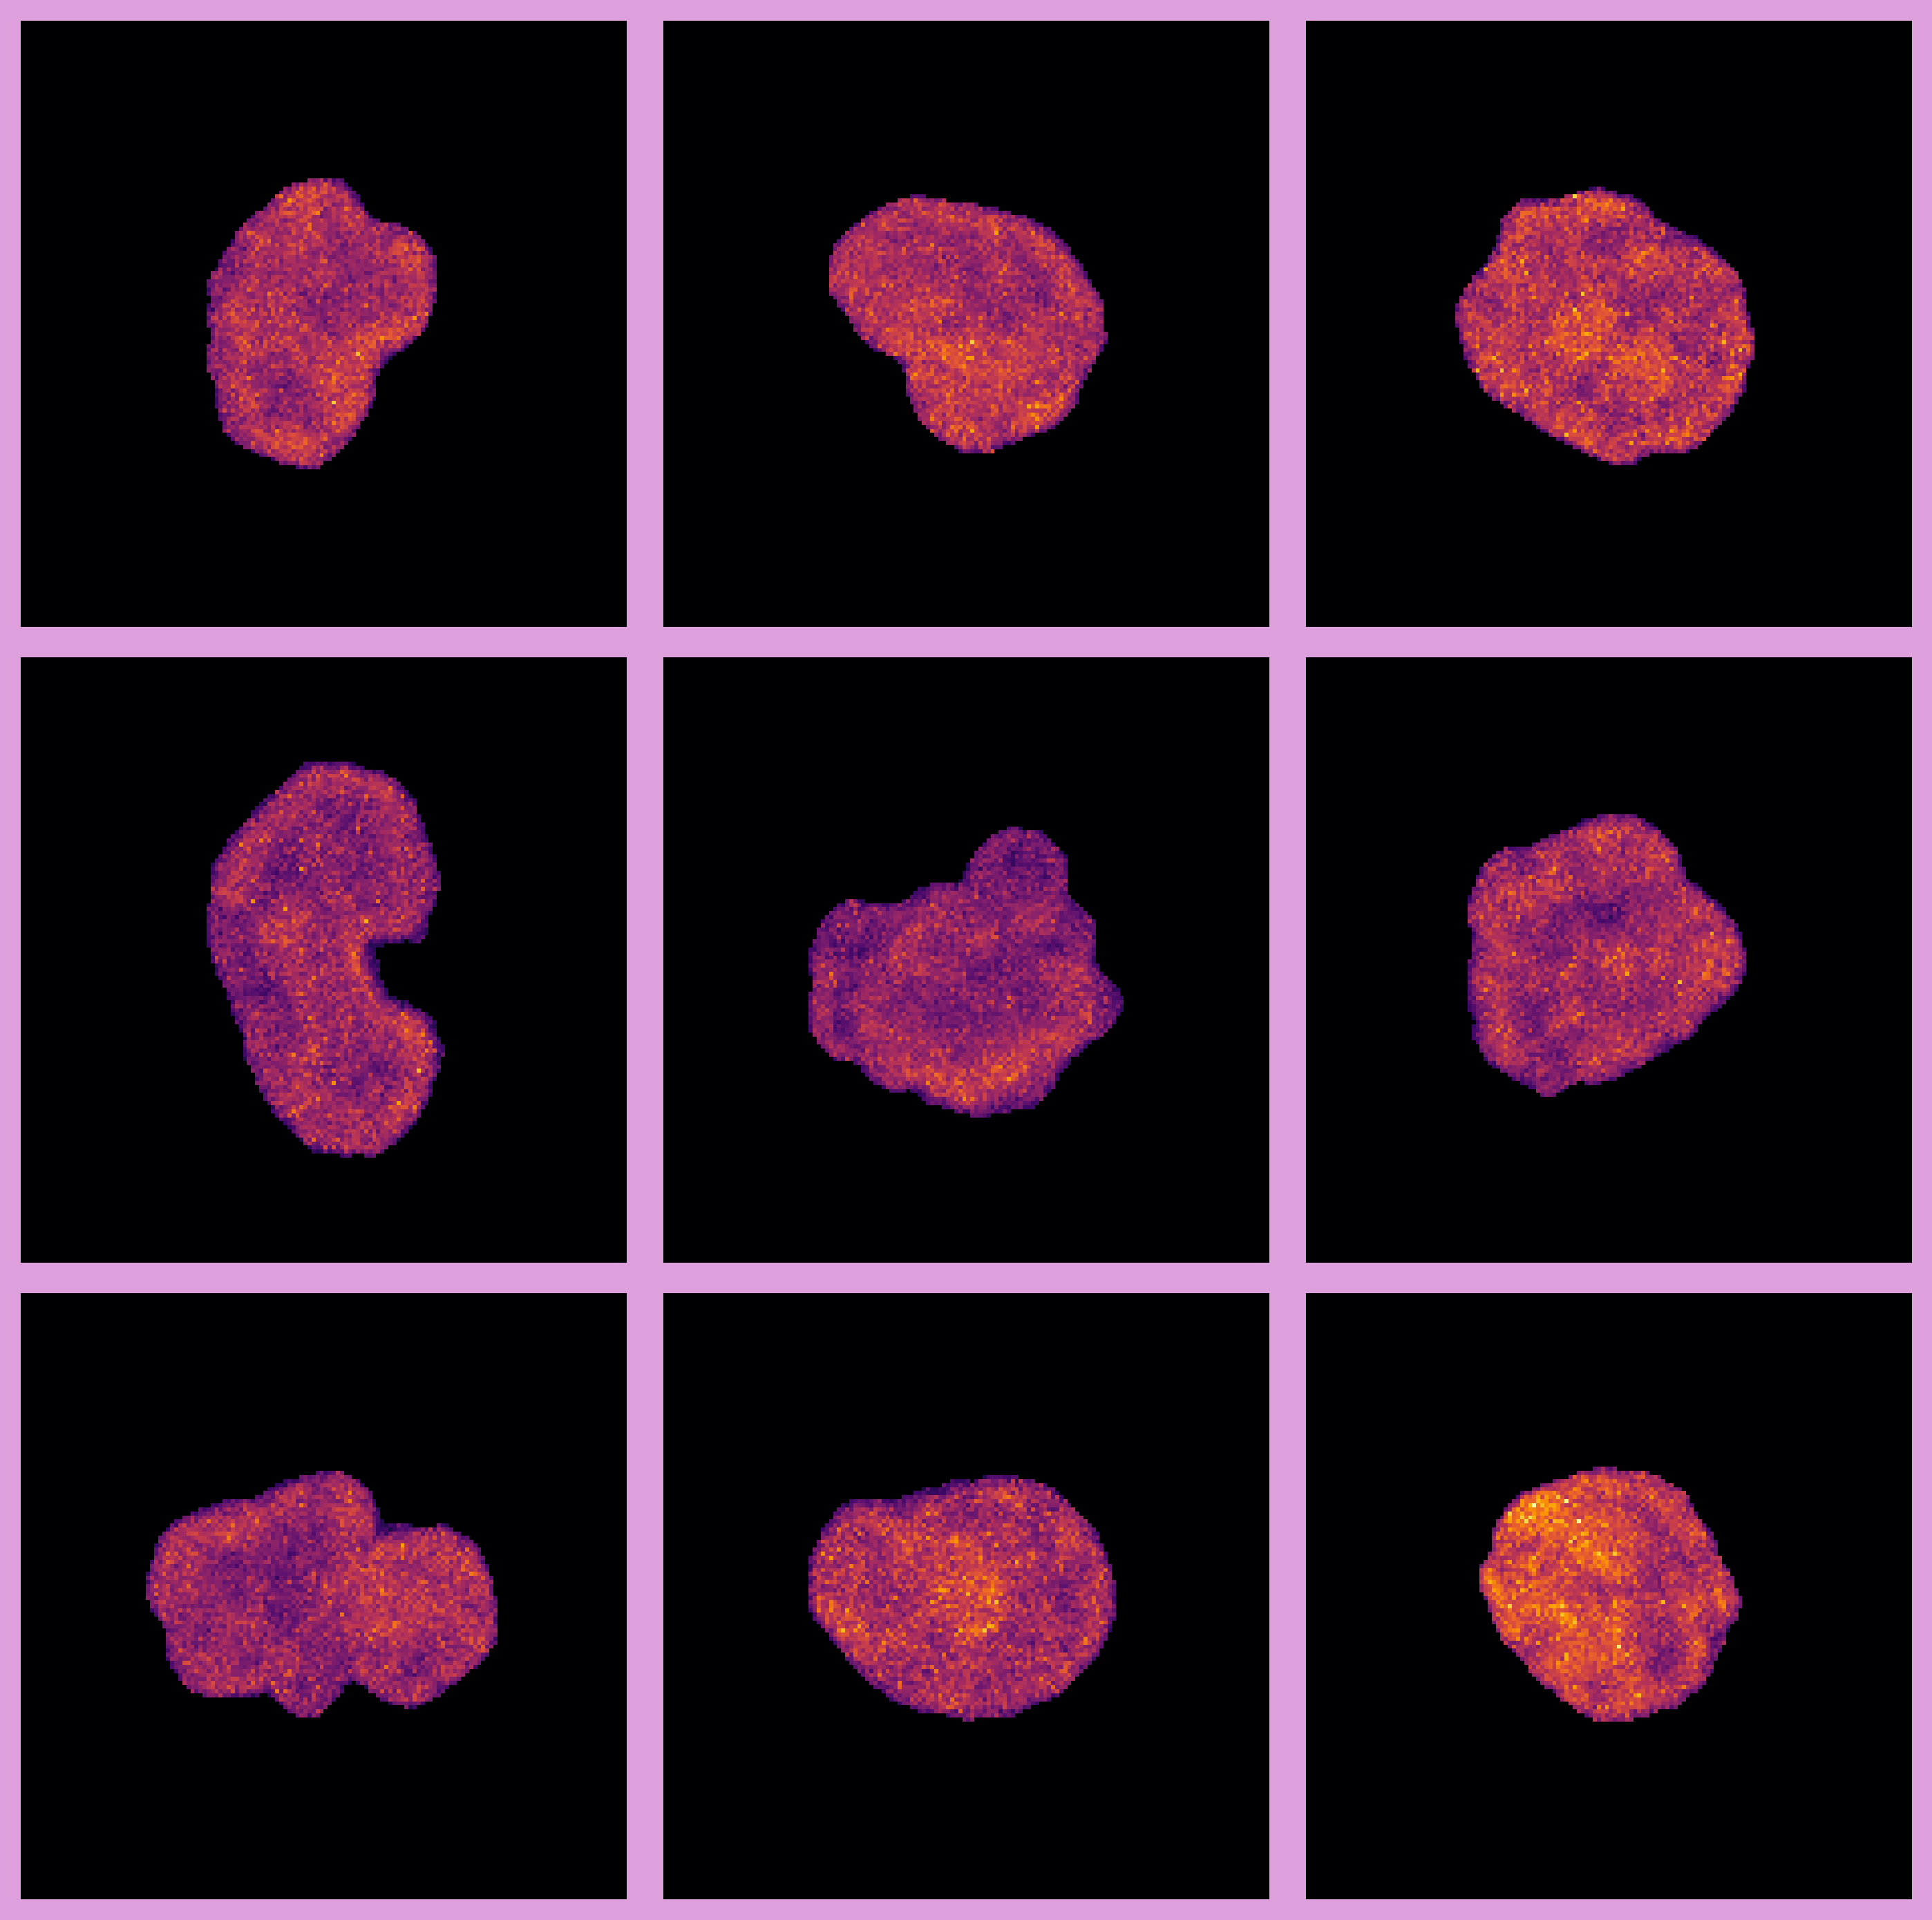

<IPython.core.display.Javascript object>

In [17]:
fig_tp1, ax_tp1 = plot_montage(
    sampled_tp1_images,
    pad_size=150,
    mask_nuclei=True,
    cmap="inferno",
    nrows=3,
    ncols=3,
)
fig_tp1.set_facecolor(color_palette["prior"])

#### During treatment population

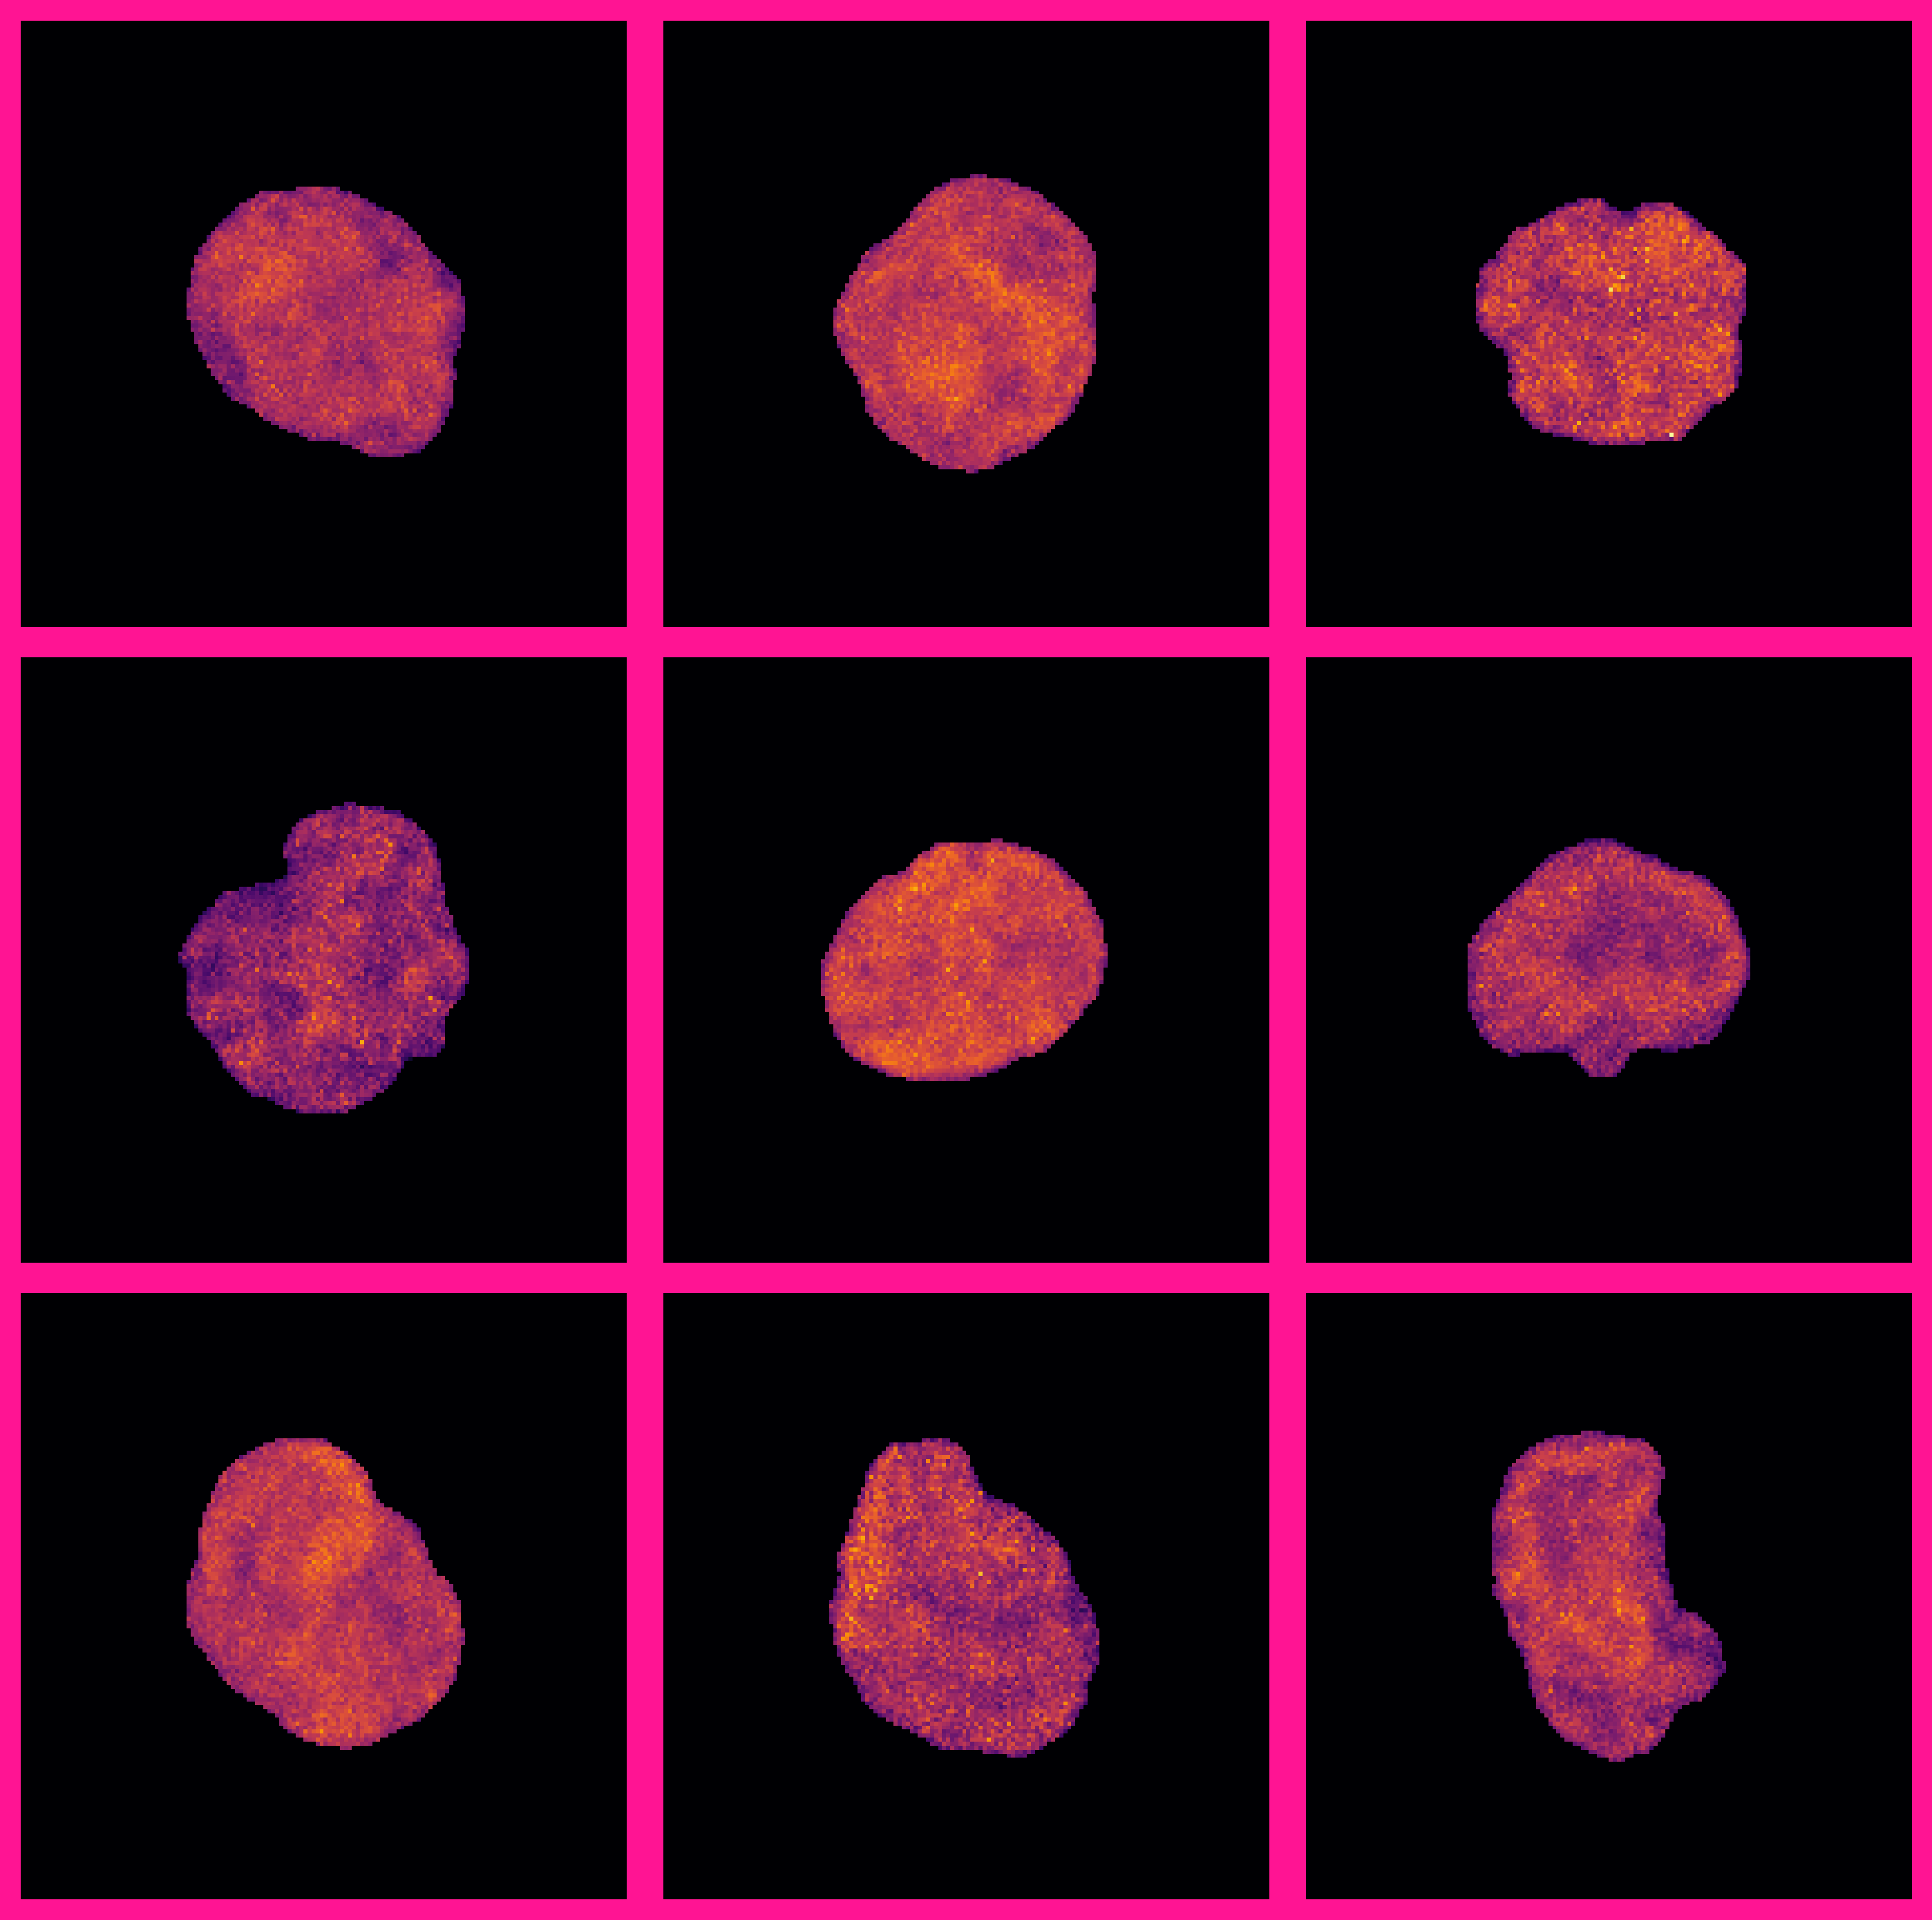

<IPython.core.display.Javascript object>

In [18]:
fig_tp2, ax_tp2 = plot_montage(
    sampled_tp2_images,
    pad_size=150,
    mask_nuclei=True,
    cmap="inferno",
    ncols=3,
    nrows=3,
)
fig_tp2.set_facecolor(color_palette["during"])

#### End of treatment population

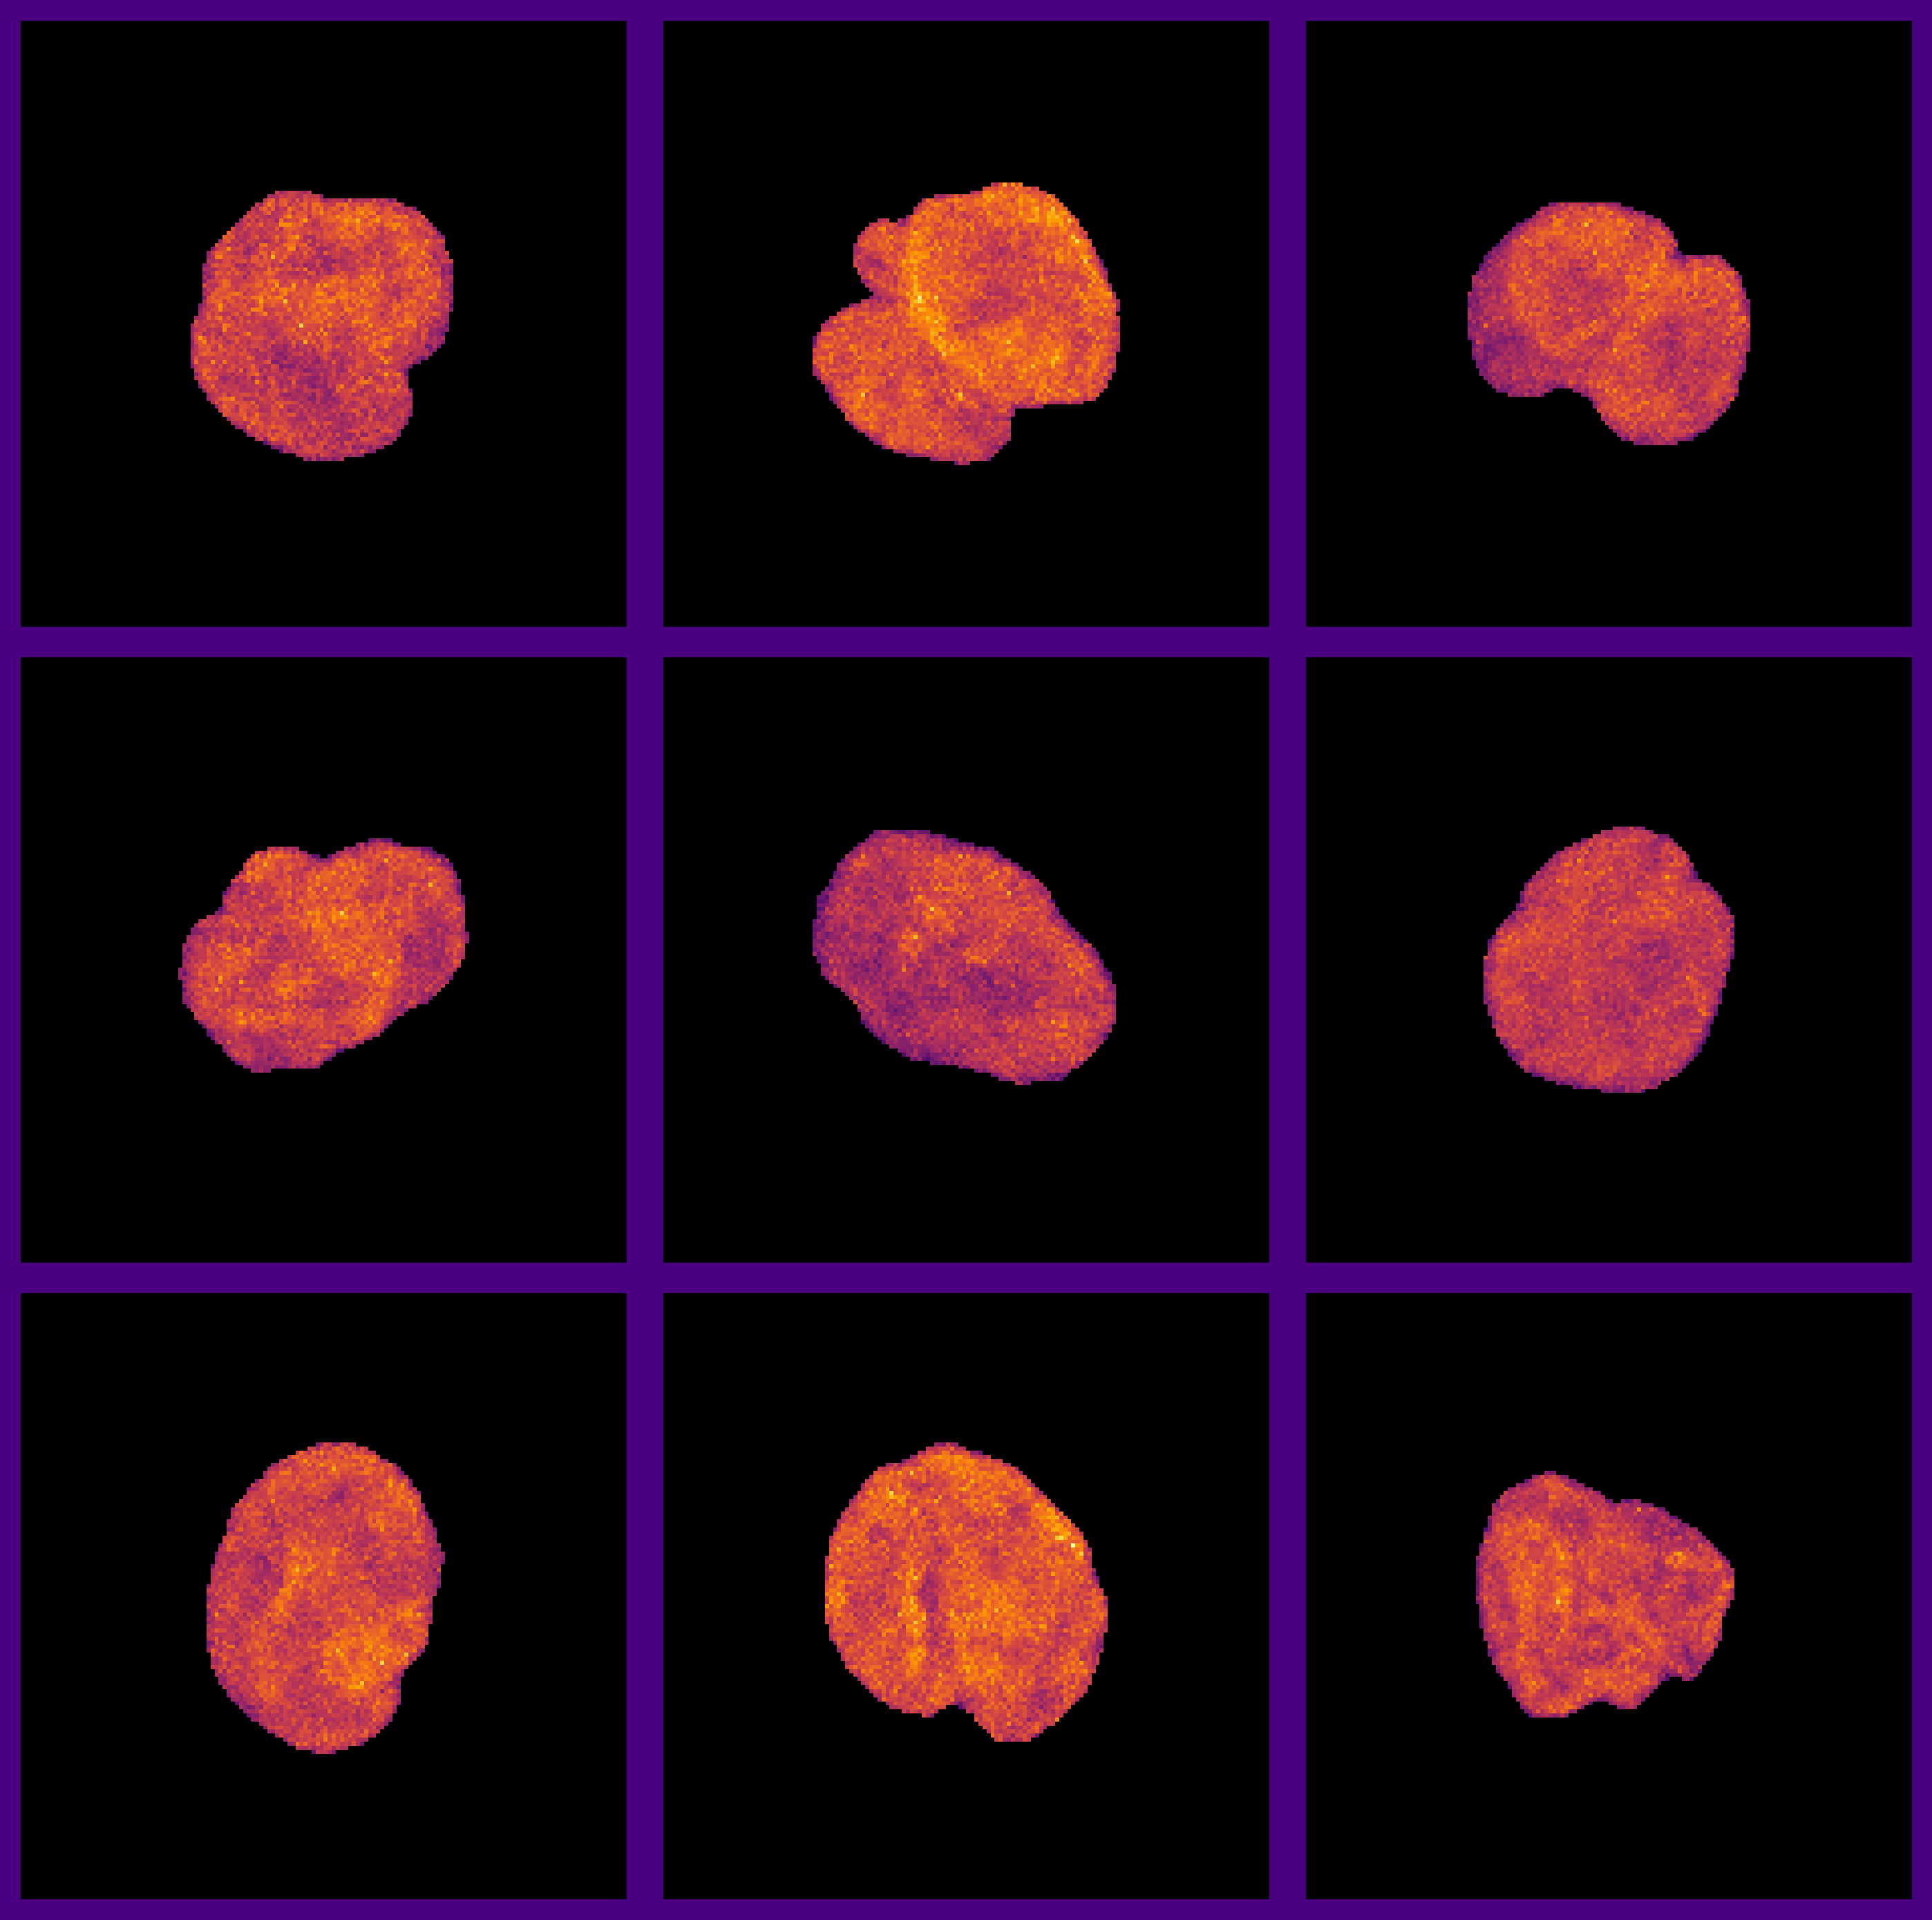

<IPython.core.display.Javascript object>

In [19]:
fig_tp3, ax_tp3 = plot_montage(
    sampled_tp3_images,
    pad_size=150,
    mask_nuclei=True,
    cmap="inferno",
    ncols=3,
    nrows=3,
)
fig_tp3.set_facecolor(color_palette["end"])

---

### 3b. Parametric analysis captures captures differences of PBMCs at different timepoints of the proton therapy treatment

The montage already indicate significant changes in particular between the chrometric pheontype of the PBMCs prior the treatment and the end of it. We will now turn to the assessment of the parametric descriptions of the nuclear phenotypes of the PBMCs at those different timepoints. To this end, we first visualize the data set using a tSNE plot to assess potential large-scale differences between the timepoint populations and individual patient samples.

In [20]:
chrometric_embs = get_tsne_embs(chrometric_data)
chrometric_embs["timepoint"] = np.array(tp_labels)
chrometric_embs["sample"] = np.array(sample_labels)

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<IPython.core.display.Javascript object>

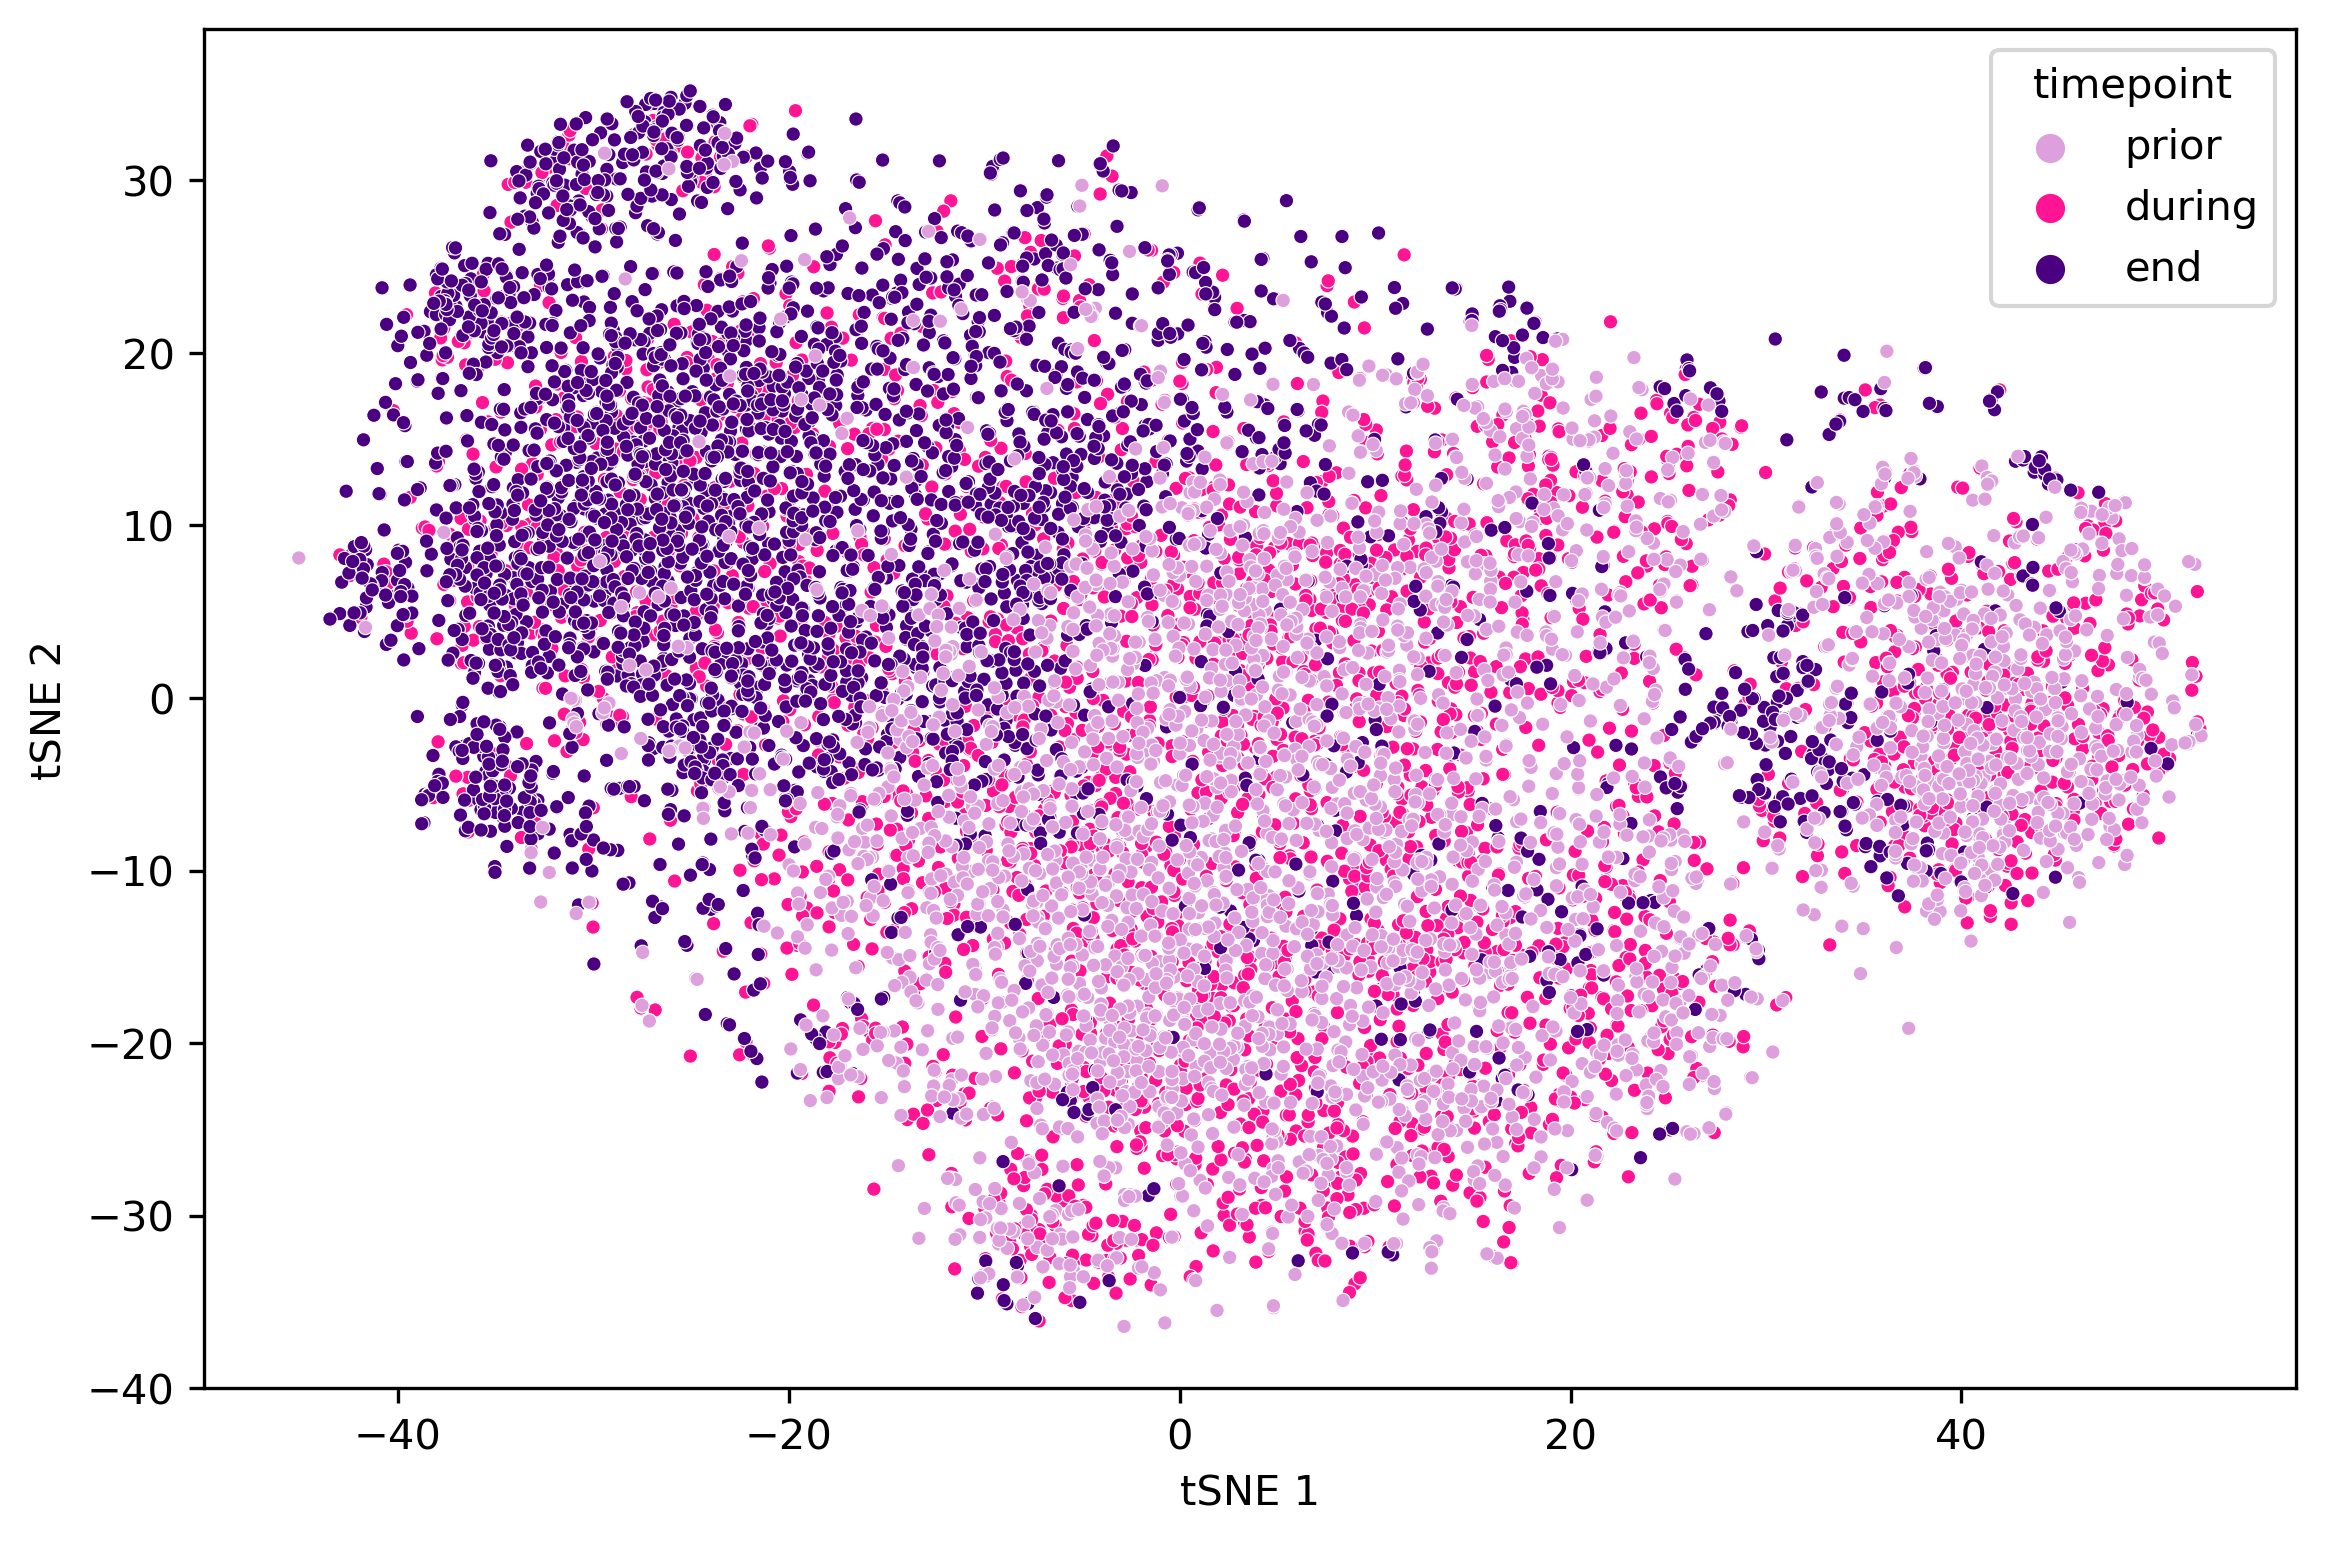

<IPython.core.display.Javascript object>

In [46]:
fig, ax = plt.subplots(figsize=[9, 6])
ax = sns.scatterplot(
    data=chrometric_embs,
    x="tSNE 1",
    y="tSNE 2",
    hue="timepoint",
    hue_order=tp_order,
    # style="timepoint",
    ax=ax,
    s=12,
    # marker="o",
    palette=color_palette,
)
plt.show()

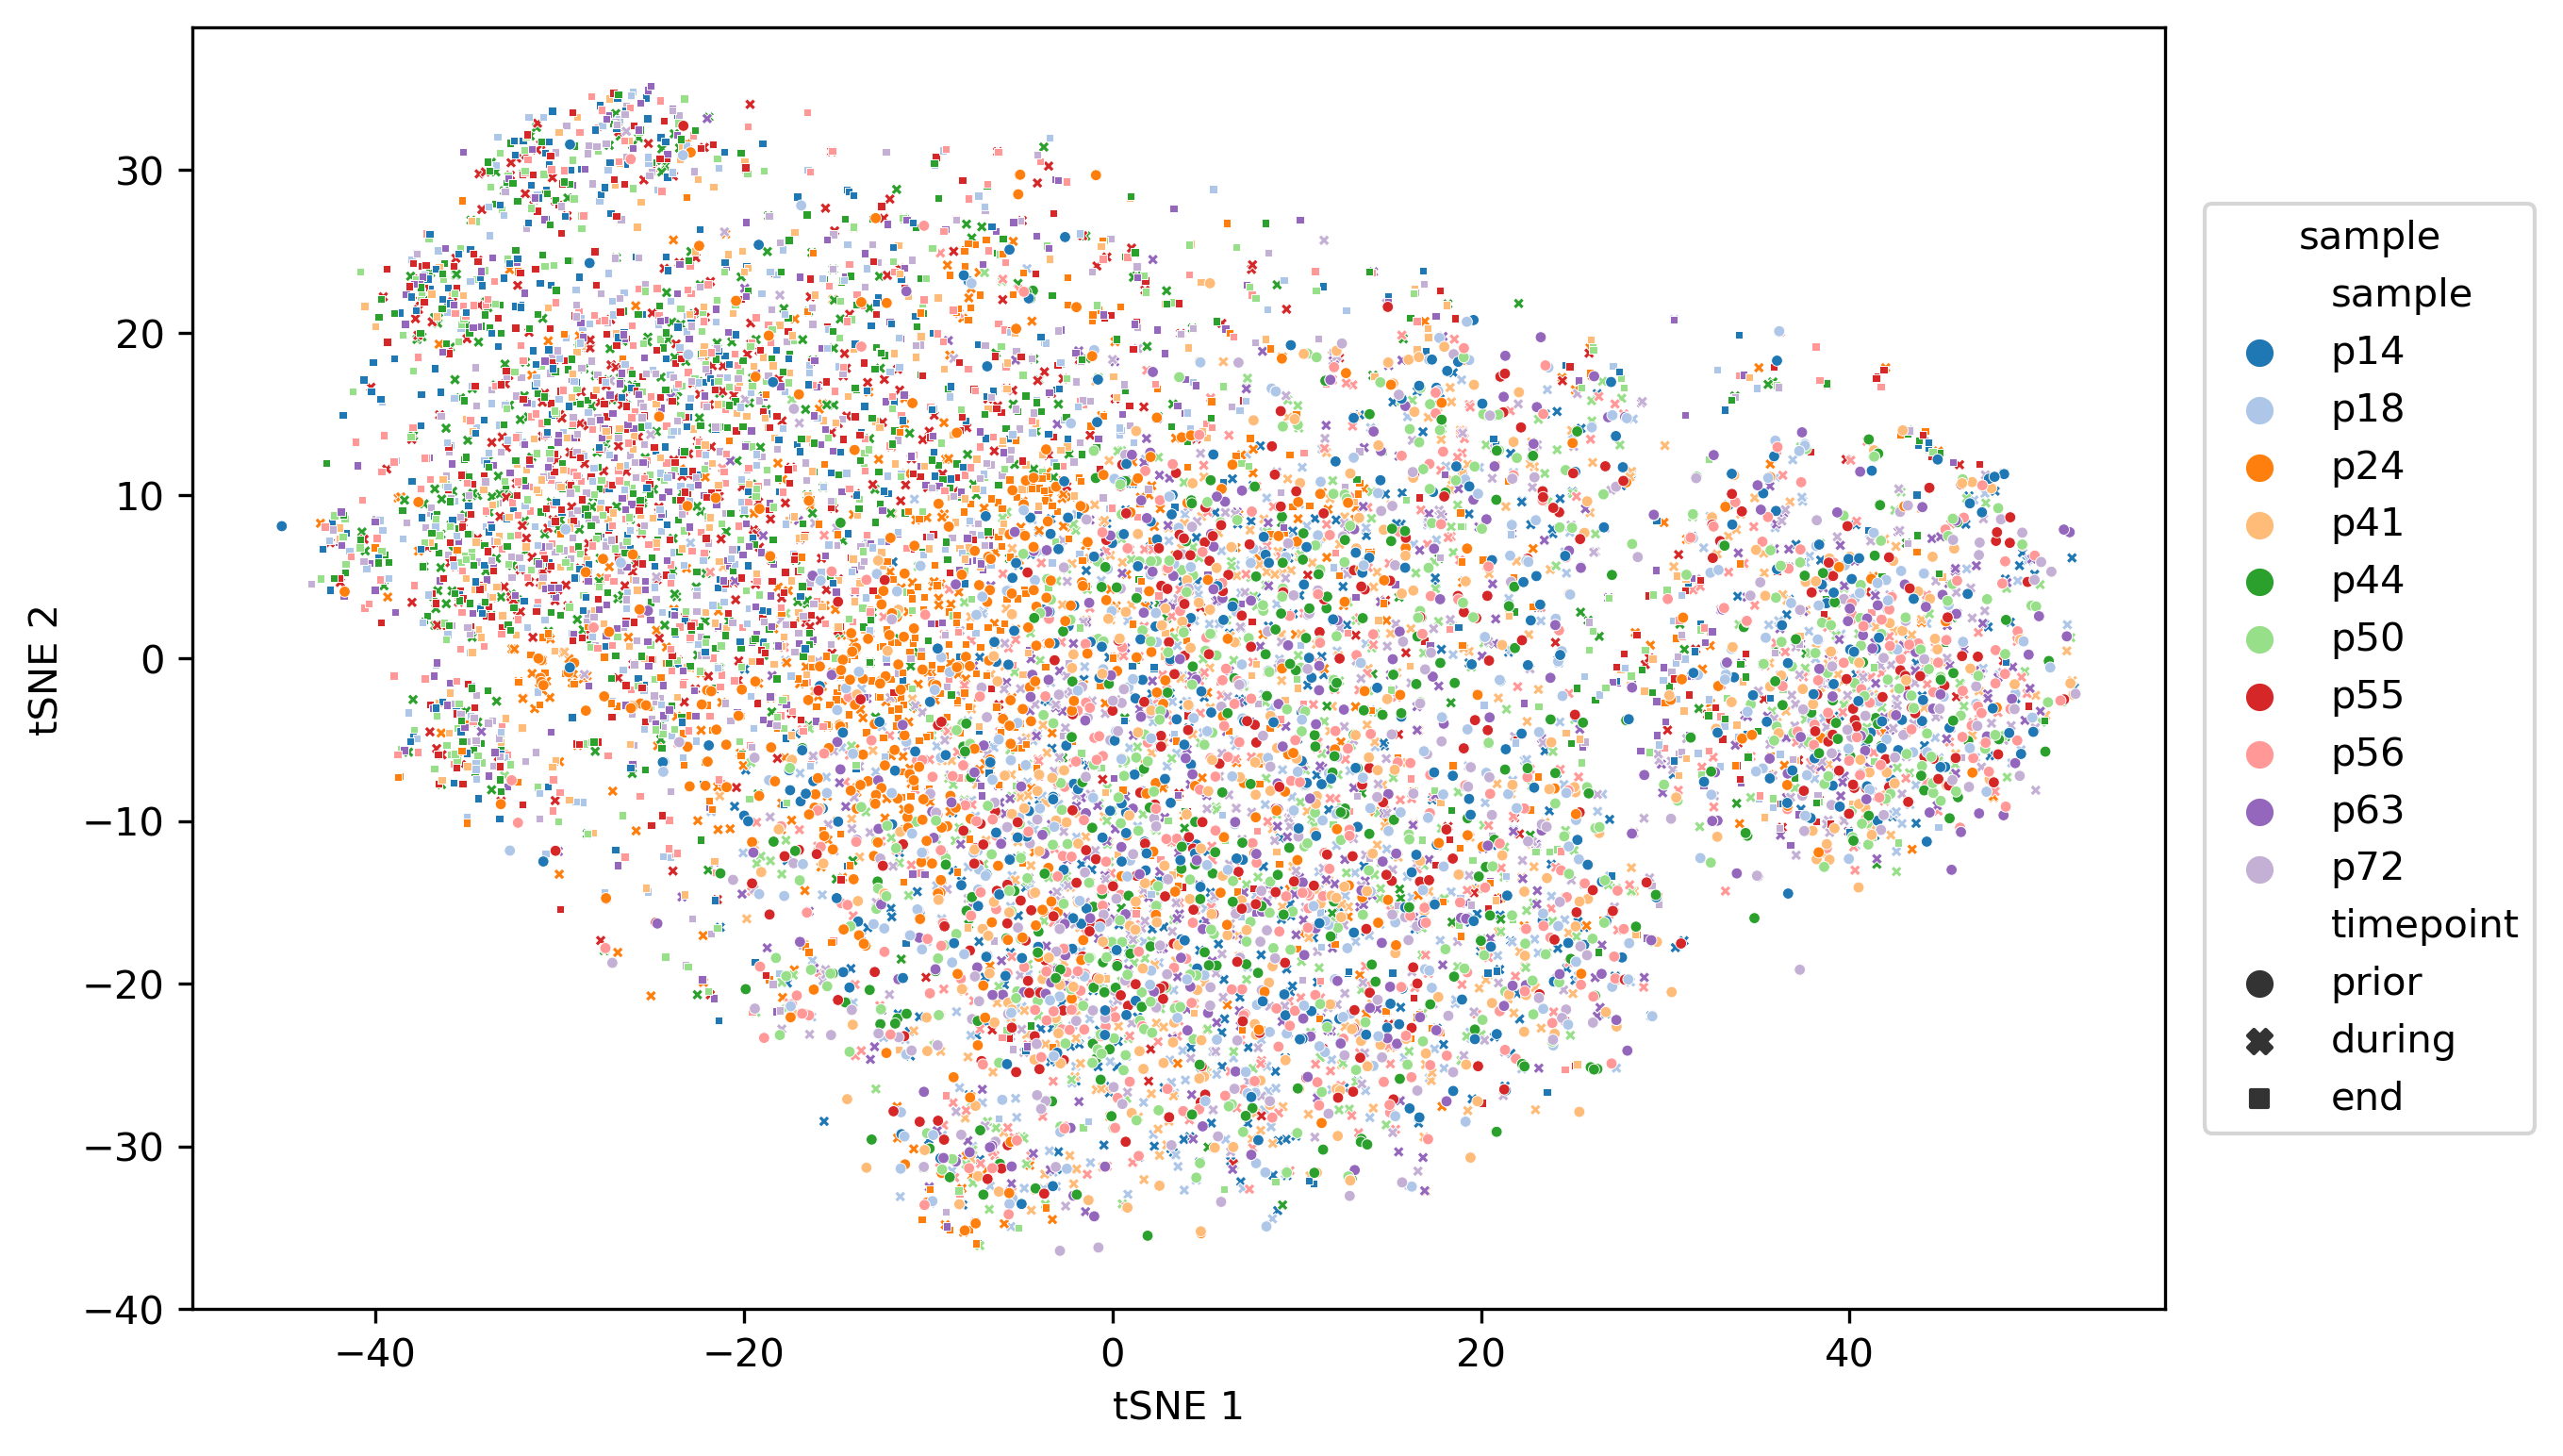

<IPython.core.display.Javascript object>

In [22]:
fig, ax = plt.subplots(figsize=[9, 6])
ax = sns.scatterplot(
    data=chrometric_embs,
    x="tSNE 1",
    y="tSNE 2",
    hue="sample",
    style="timepoint",
    style_order=tp_order,
    hue_order=sample_order,
    ax=ax,
    s=8,
    marker="o",
    palette="tab20",
)
plt.legend(
    bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0, title="sample"
)
plt.show()

The tSNE plot also shows that especially the chrometric phenotypes of the PBMCs at the end of the proton therapy look different from the prior and the during treatment population.
The patient samples are fairly well mixed with the exception of potentially P24.

---

#### Classification of the different cancer types.

To quantify the separability of the timepoint populations using the chrometric phenotypes of the PBMCs of the different cancer patients we perform a 10-fold stratified cross-validation analysis using a RandomForest classifier. The classifier provides a simple non-linear classification model which also yields an importance measure for the individual chrometric features indicating which ones are most different between the three populations.

##### Nuclei split

At first we will split the data randomly on a nuclei-basis, i.e. nuclei of the same patient will be likely included in both the training and the test sets.

In [23]:
rfc = RandomForestClassifier(
    n_estimators=500, n_jobs=10, random_state=seed, class_weight="balanced"
)

<IPython.core.display.Javascript object>

In [24]:
tp_cv_conf_mtx_nuclei = get_cv_conf_mtx(
    estimator=rfc,
    features=chrometric_data,
    labels=tp_labels,
    scale_features=False,
    n_folds=3,
    order=tp_order,
)
normalized_cv_conf_mtx_nuclei = tp_cv_conf_mtx_nuclei.divide(
    tp_cv_conf_mtx_nuclei.sum(axis=1), axis=0
)

<IPython.core.display.Javascript object>

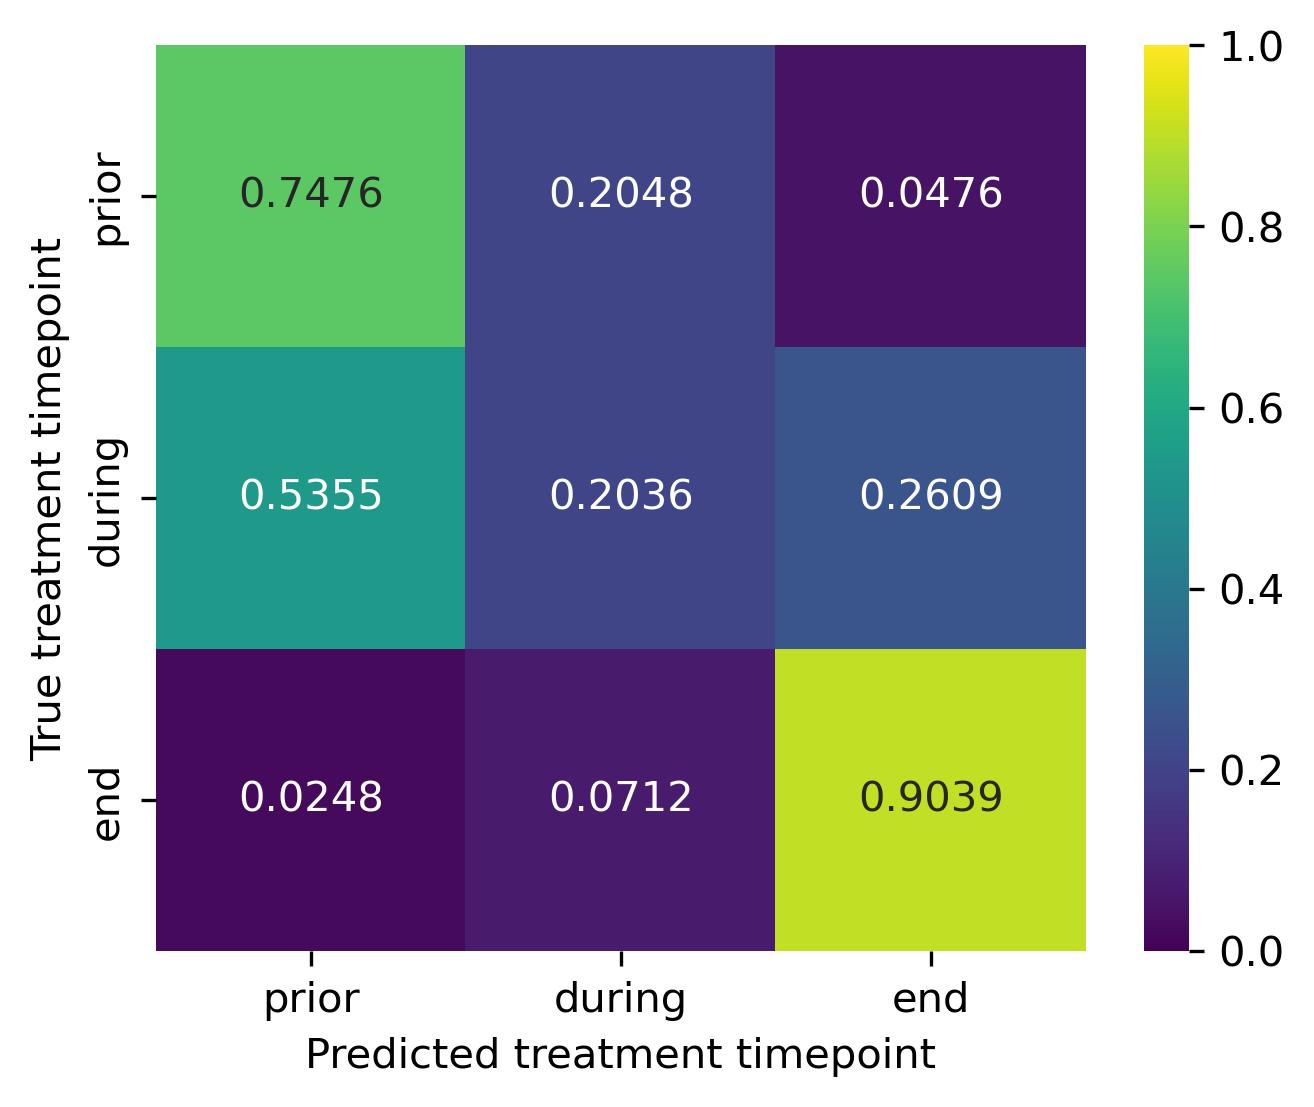

<IPython.core.display.Javascript object>

In [25]:
fig, ax = plt.subplots(figsize=[5, 4])
ax = sns.heatmap(
    normalized_cv_conf_mtx_nuclei,
    annot=True,
    fmt=".4f",
    cmap="viridis",
    vmin=0,
    vmax=1,
    # cbar=False,
)
ax.set_xlabel("Predicted treatment timepoint")
ax.set_ylabel("True treatment timepoint")
plt.show()

The classifier is only able to accurately distinguish nuclei from the prior and the end of treatment timepoint populations which suggests that the during treatment population features both phenotypes frequently encountered prior and at the end of treatment.

To further assess the similarity of the different timepoint distribution and their linear separability we use a linear discriminant analysis.

In [26]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda_tp_cv_conf_mtx_nuclei = get_cv_conf_mtx(
    estimator=lda,
    features=chrometric_data,
    labels=tp_labels,
    scale_features=True,
    n_folds=10,
    order=tp_order,
)
lda_normalized_cv_conf_mtx_nuclei = lda_tp_cv_conf_mtx_nuclei.divide(
    lda_tp_cv_conf_mtx_nuclei.sum(axis=1), axis=0
)

<IPython.core.display.Javascript object>

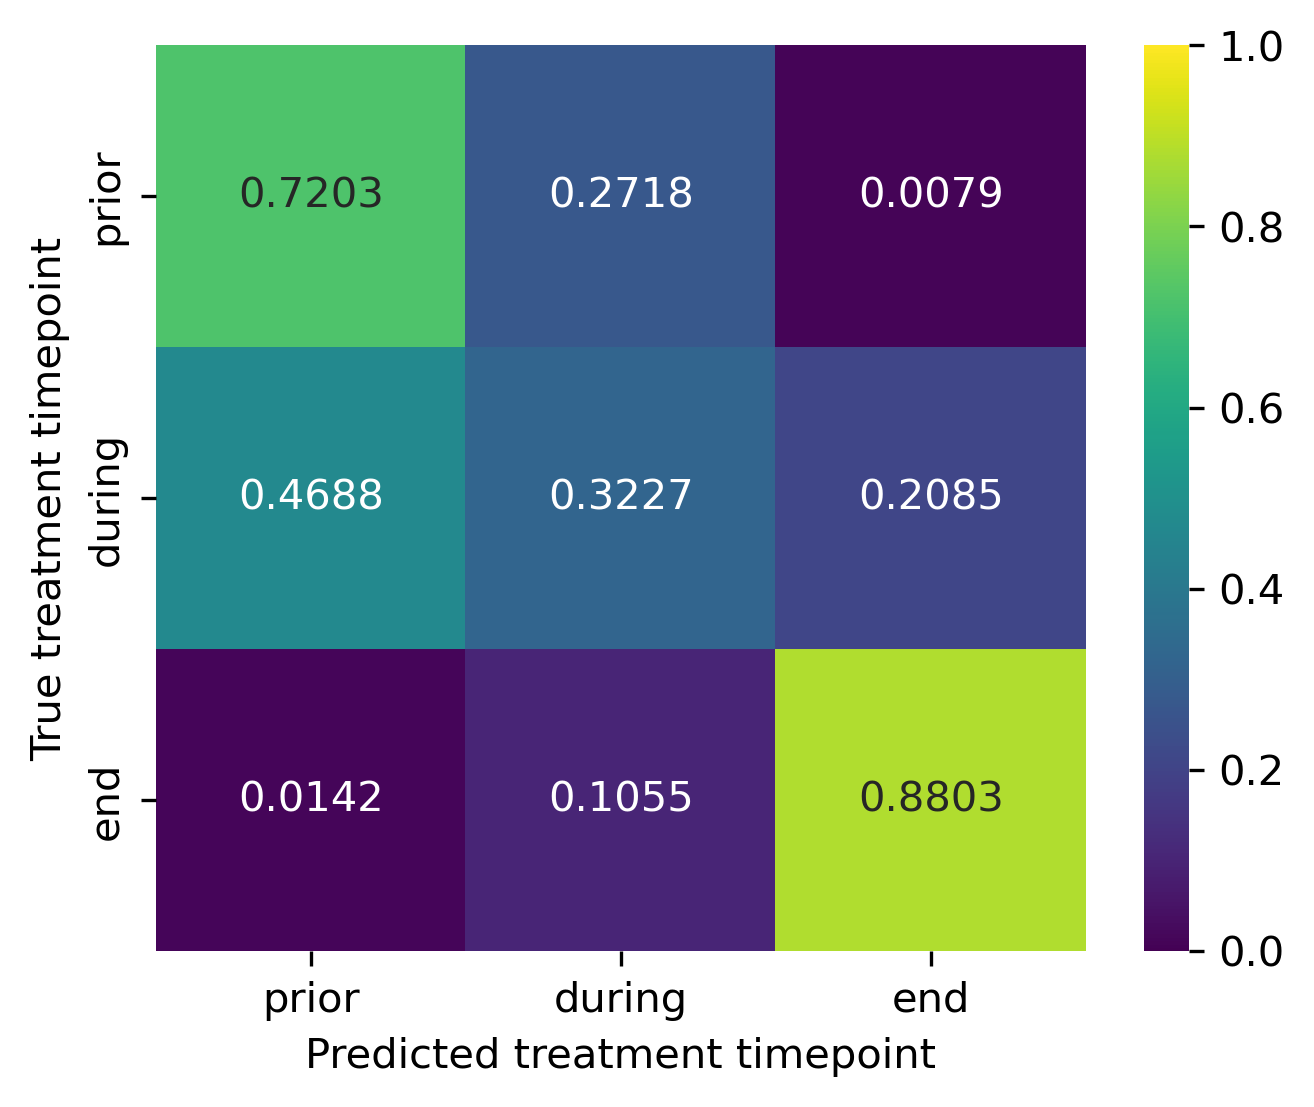

<IPython.core.display.Javascript object>

In [27]:
fig, ax = plt.subplots(figsize=[5, 4])
ax = sns.heatmap(
    lda_normalized_cv_conf_mtx_nuclei,
    annot=True,
    fmt=".4f",
    cmap="viridis",
    vmin=0,
    vmax=1,
    # cbar=False,
)
ax.set_xlabel("Predicted treatment timepoint")
ax.set_ylabel("True treatment timepoint")
plt.show()

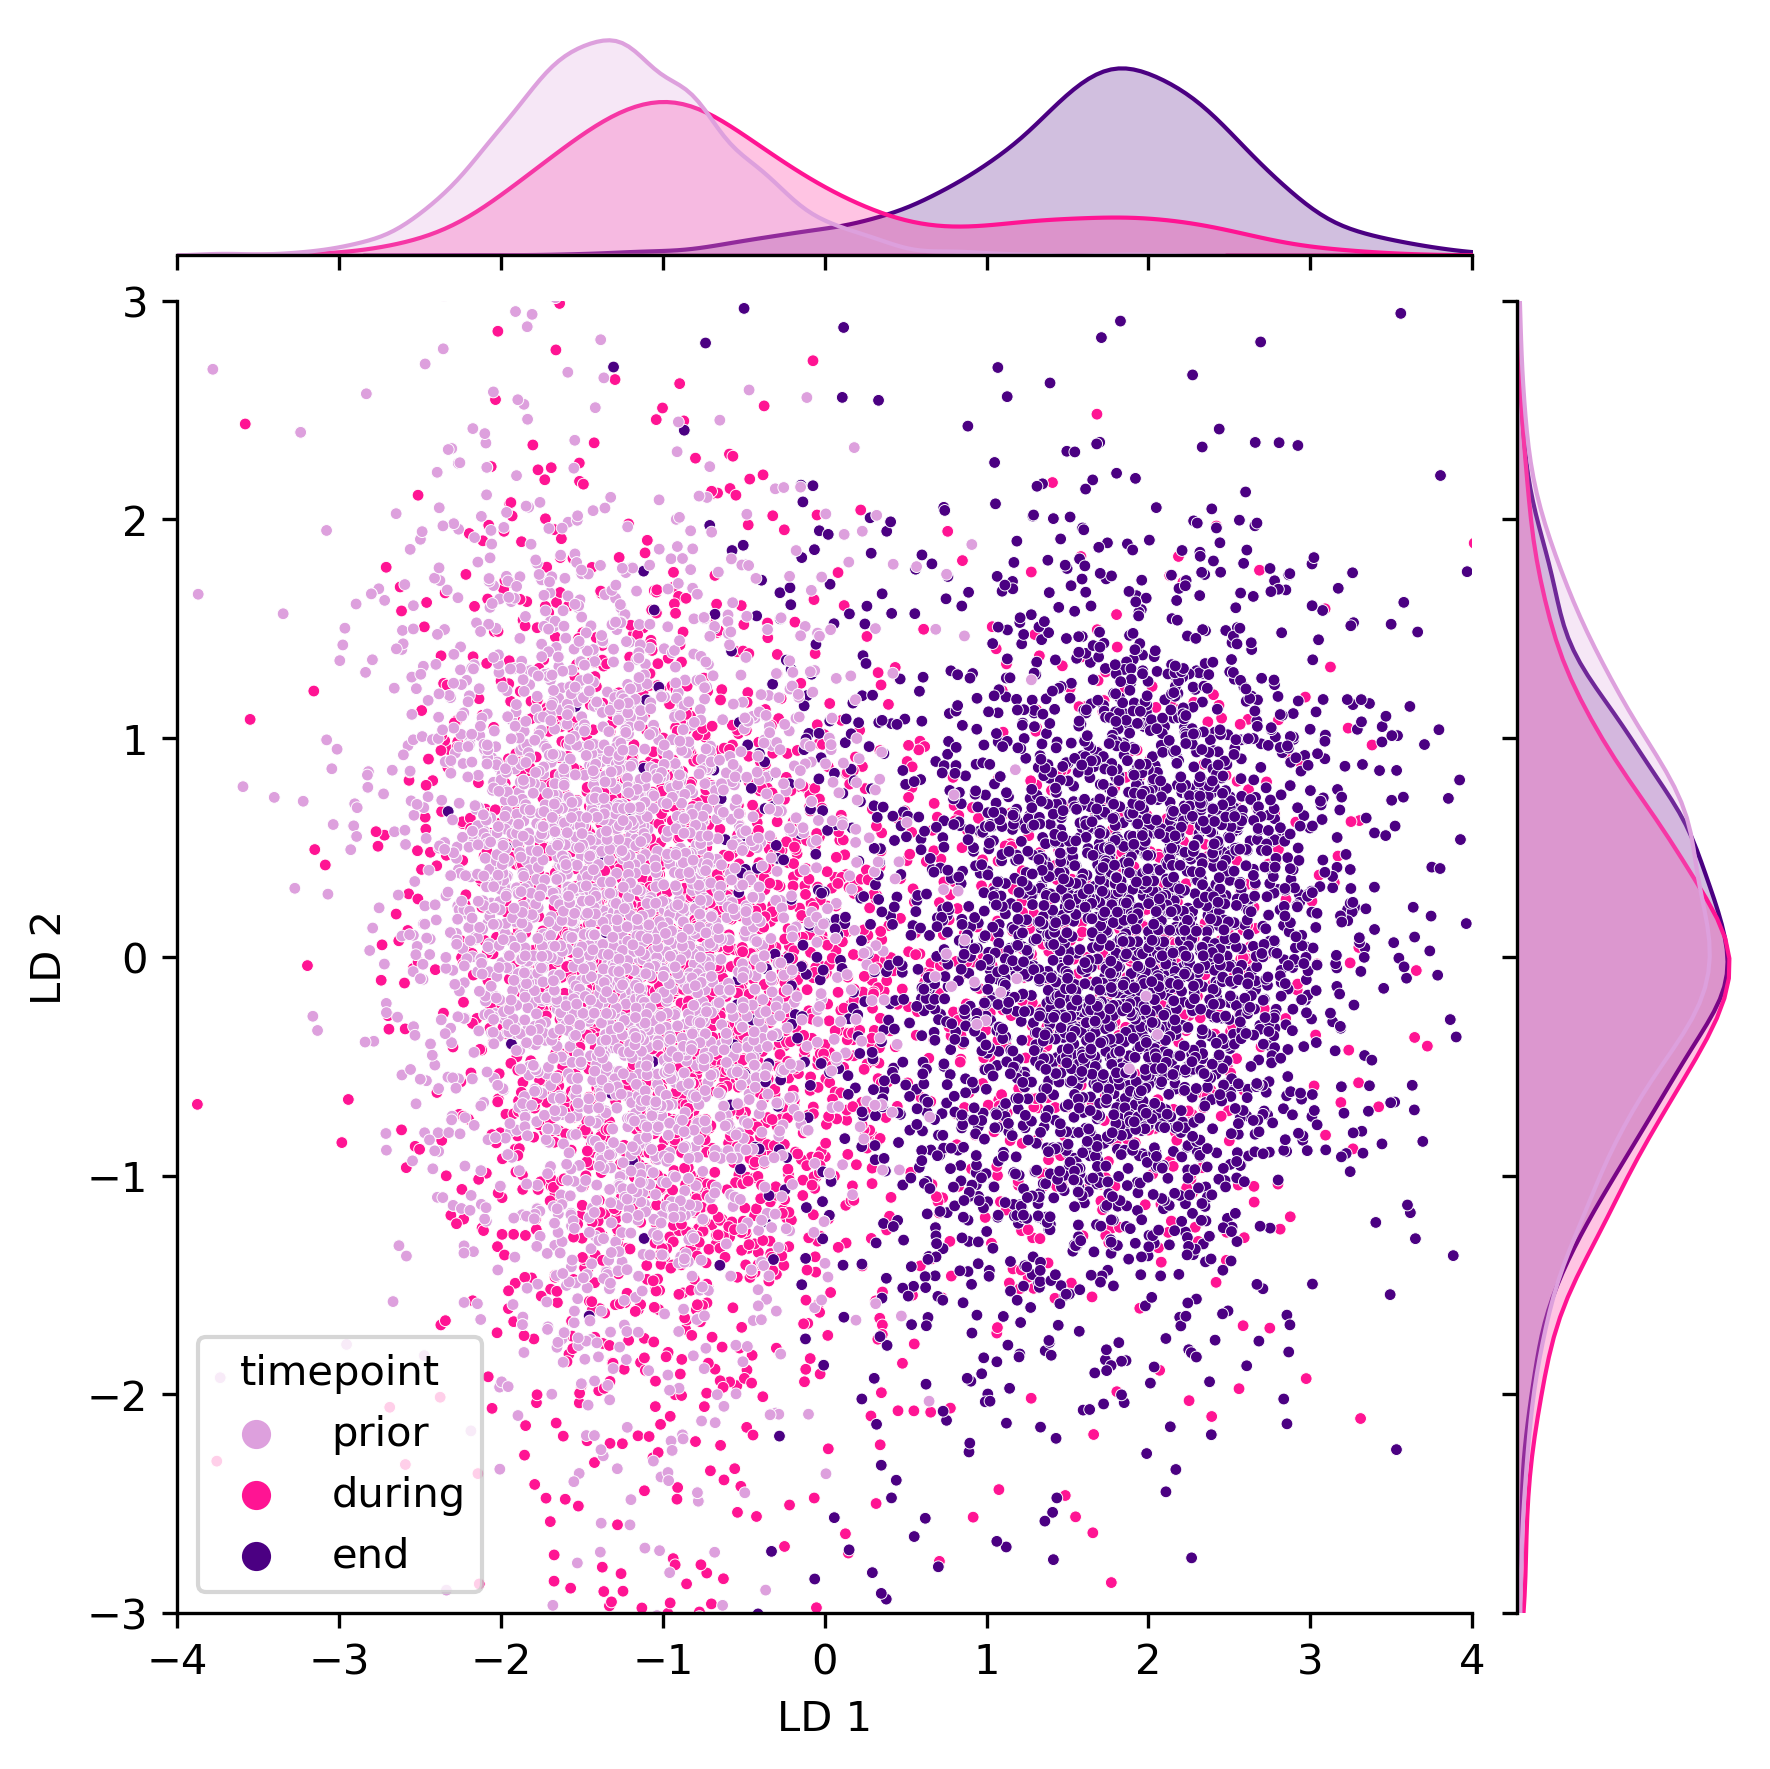

<IPython.core.display.Javascript object>

In [48]:
lda_transformed = pd.DataFrame(
    lda.fit(chrometric_data, tp_labels).transform(chrometric_data),
    columns=["LD 1", "LD 2"],
    index=chrometric_data.index,
)
lda_transformed["timepoint"] = np.array(tp_labels)
lda_transformed["sample"] = np.array(sample_labels)
g = sns.jointplot(
    data=lda_transformed,
    x="LD 1",
    y="LD 2",
    hue="timepoint",
    s=8,
    hue_order=tp_order,
    height=6,
    palette=color_palette,
    xlim=[-4, 4],
    ylim=[-3, 3],
)

In [29]:
np.sum(np.abs(lda_transformed.loc[:, "LD 1"]) > 4) + np.sum(
    np.abs(lda_transformed.loc[:, "LD 2"]) > 3
)

111

<IPython.core.display.Javascript object>

The above LDA plot suggests in addition to the confusion matrix that the indeed the population of the PBMCs prior and the end of the treatment of the proton therapy look more alike compared to those during the treatment.

Note that in the above plot 32 outlier sample is excluded for better visualization of the population differences.

---
#### Patient split


While the previous analysis assess the level of differences of the chrometric phenotypes of the PBMCs between the different treatment timepoints, the classifier can make use of patient specific characteristics during the classification. In a diagnostic use case such information would not be available. To evaluate how well a classifier would be able to predict for unseen patient the corresponding treatment timepoint simply based on the chrometric phenotypes of the PBMCs, we also assess the class separability using a stratified 5-fold patient-cross-validation approach. Thereby at each iteration 1-2 of the patients of each timepoint are hold out for the test set.

In [30]:
tp_cv_conf_mtx_patient = get_cv_conf_mtx(
    estimator=rfc,
    features=chrometric_data,
    labels=tp_labels,
    groups=sample_labels,
    scale_features=False,
    n_folds=5,
    order=tp_order,
)
normalized_cv_conf_mtx_patient = tp_cv_conf_mtx_patient.divide(
    tp_cv_conf_mtx_patient.sum(axis=1), axis=0
)

<IPython.core.display.Javascript object>

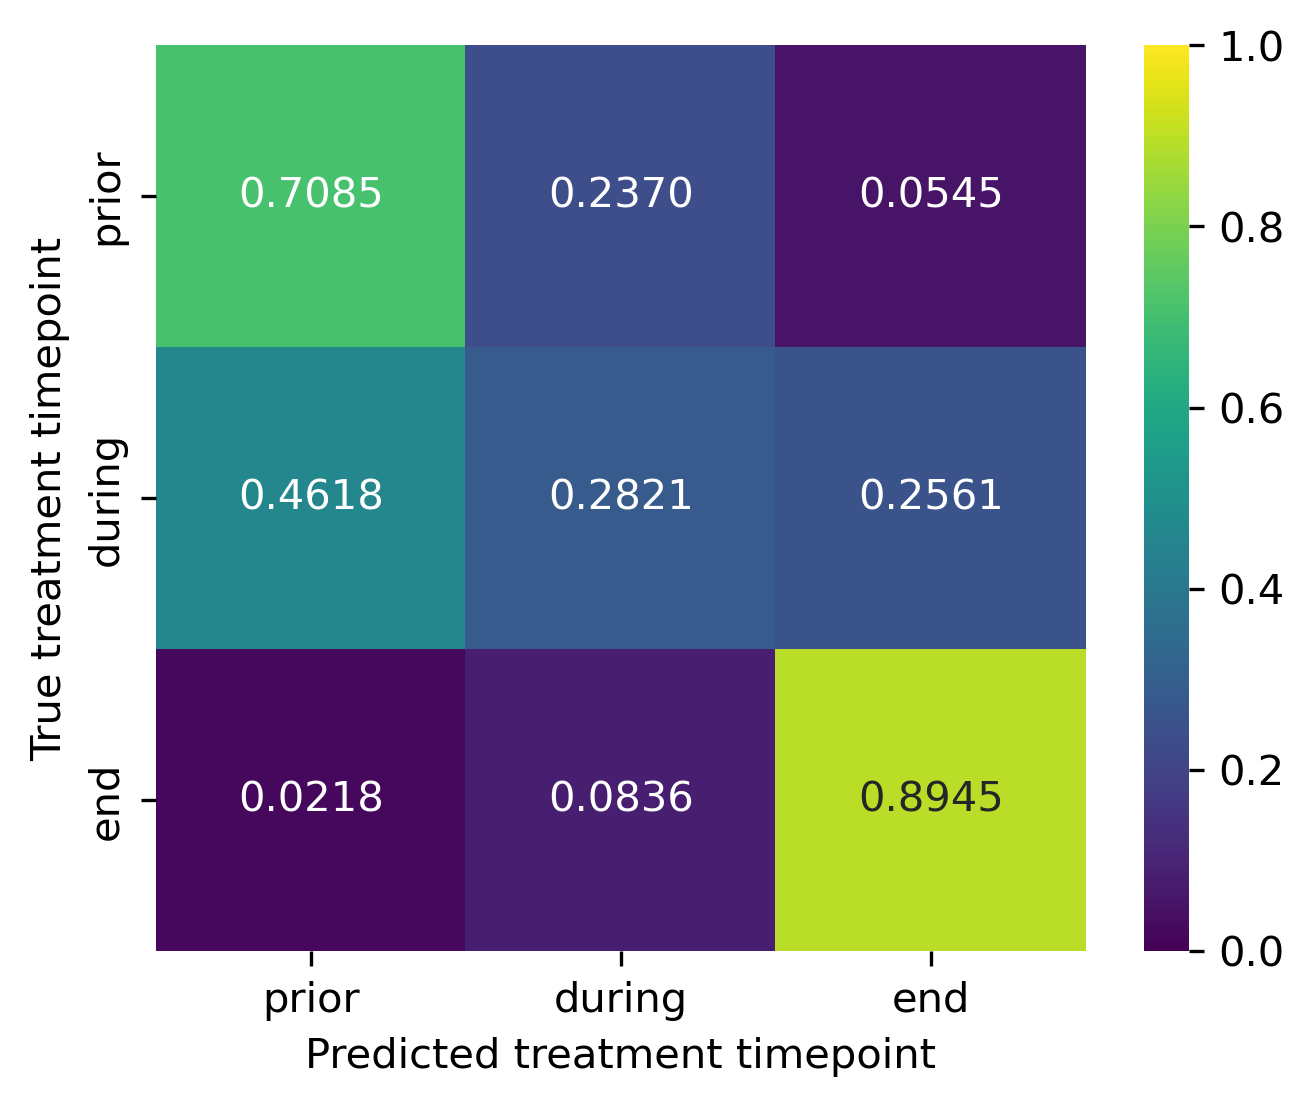

<IPython.core.display.Javascript object>

In [31]:
fig, ax = plt.subplots(figsize=[5, 4])
ax = sns.heatmap(
    normalized_cv_conf_mtx_patient,
    annot=True,
    fmt=".4f",
    cmap="viridis",
    vmin=0,
    vmax=1,
    # cbar=False,
)
ax.set_xlabel("Predicted treatment timepoint")
ax.set_ylabel("True treatment timepoint")
plt.show()

In [32]:
groupkfold = StratifiedGroupKFold(n_splits=10)
cv_bacs = cross_val_score(
    rfc,
    cv=groupkfold,
    X=chrometric_data,
    y=tp_labels,
    groups=sample_labels,
    scoring="balanced_accuracy",
    n_jobs=10,
)
print("Balanced accuracy: {} (+/- {})".format(np.mean(cv_bacs), np.std(cv_bacs)))

Balanced accuracy: 0.6441414141414141 (+/- 0.09542225951772582)


<IPython.core.display.Javascript object>

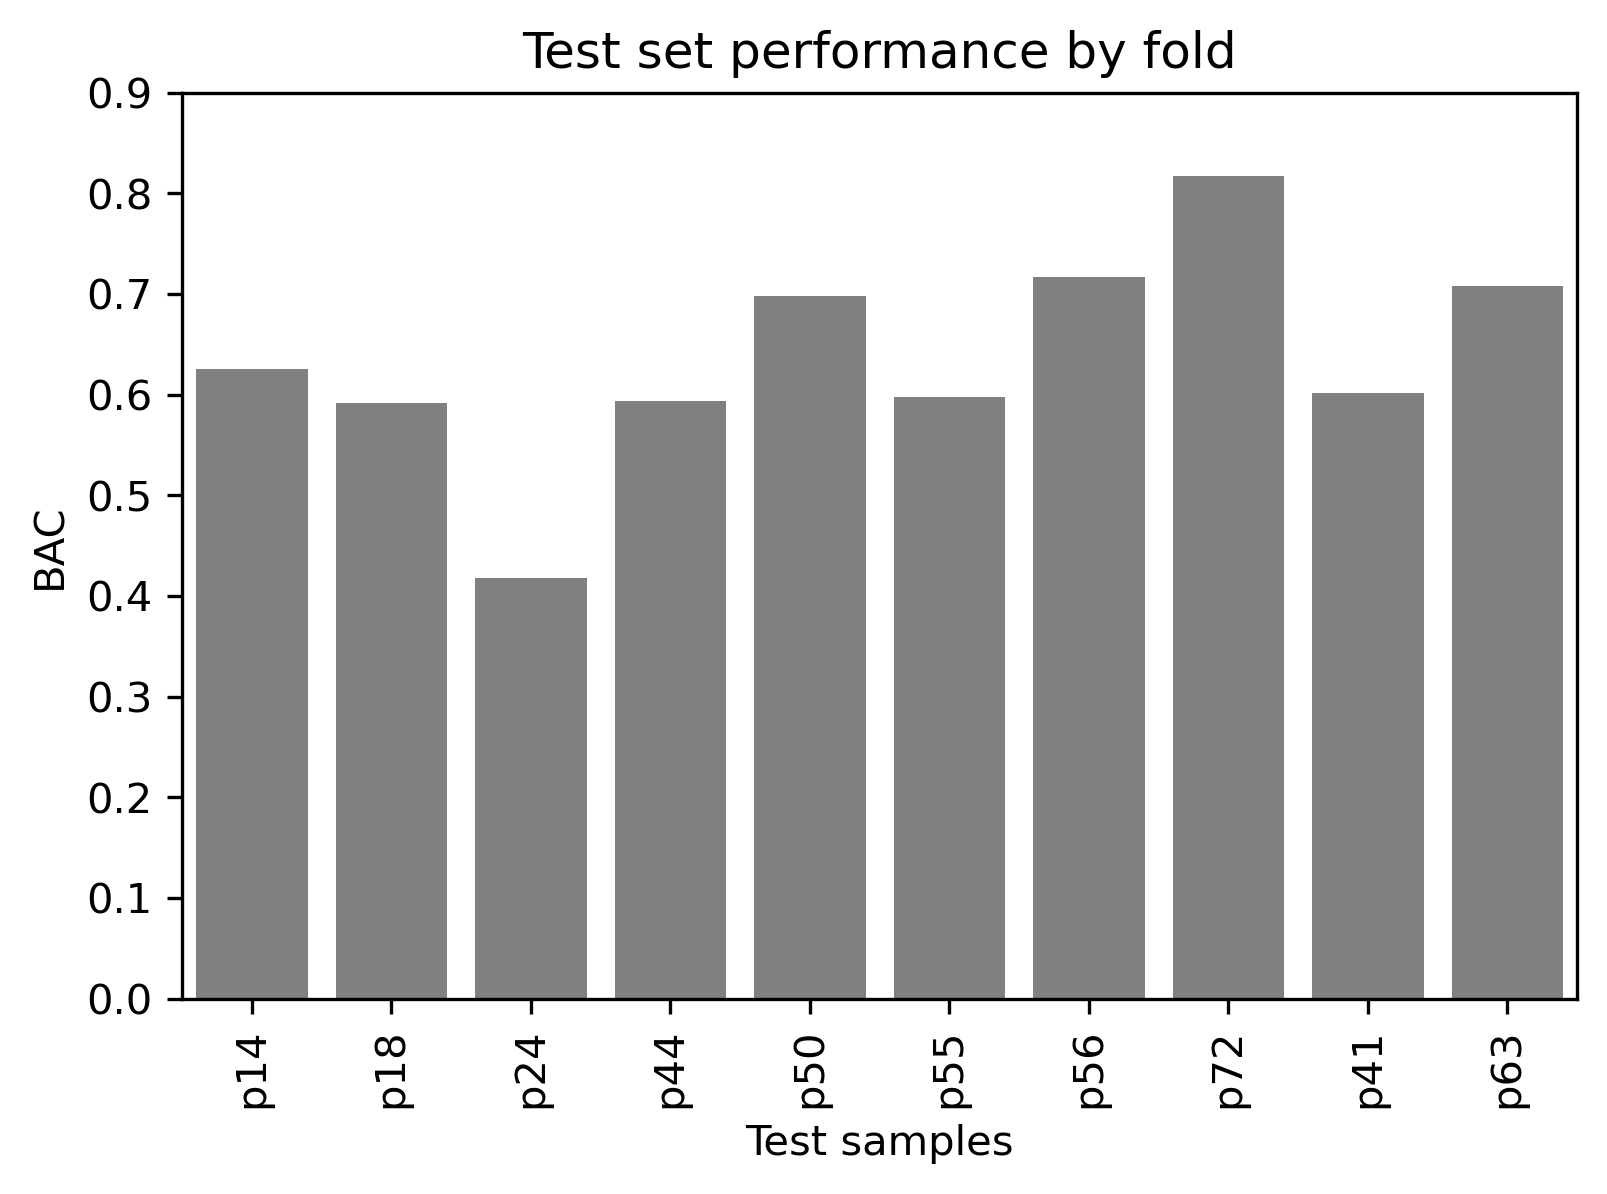

<IPython.core.display.Javascript object>

In [50]:
test_samples = []
for train_idx, test_idx in groupkfold.split(chrometric_data, tp_labels, sample_labels):
    test_samples.append("_".join(np.unique(sample_labels[test_idx])))
cv_bac_df = pd.DataFrame(cv_bacs, columns=["BAC"])
cv_bac_df["Test samples"] = test_samples
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.barplot(x="Test samples", y="BAC", data=cv_bac_df, palette=["gray"], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Test set performance by fold")
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

In [49]:
cv_bacs = cross_val_score(
    lda,
    cv=groupkfold,
    X=chrometric_data,
    y=tp_labels,
    groups=sample_labels,
    scoring="balanced_accuracy",
    n_jobs=10,
)
print("Balanced accuracy: {} (+/- {})".format(np.mean(cv_bacs), np.std(cv_bacs)))

Balanced accuracy: 0.636969696969697 (+/- 0.10114960064196786)


<IPython.core.display.Javascript object>

In general the confusion matrix again shows a similar picture as seen for the nuclei-based split showing that end of treatment population show phenotypes of the PBMCs significantly different from the other two treatment timepoints.

---

### 3c. Nuclear chromatin biomarkers identifying cancer populations

#### Feature importance

We have validated that there are significant differences between the individual treatment timepoints in particular when comparing PBMCs at the end of the treatment with those of during respectively prior the treatment. We next assess the implicit feature importance of a RandomForest classifier trained on the task to distinguish between the timepoint populations types in order to get an idea of the features are most indicative for the treatment effect.

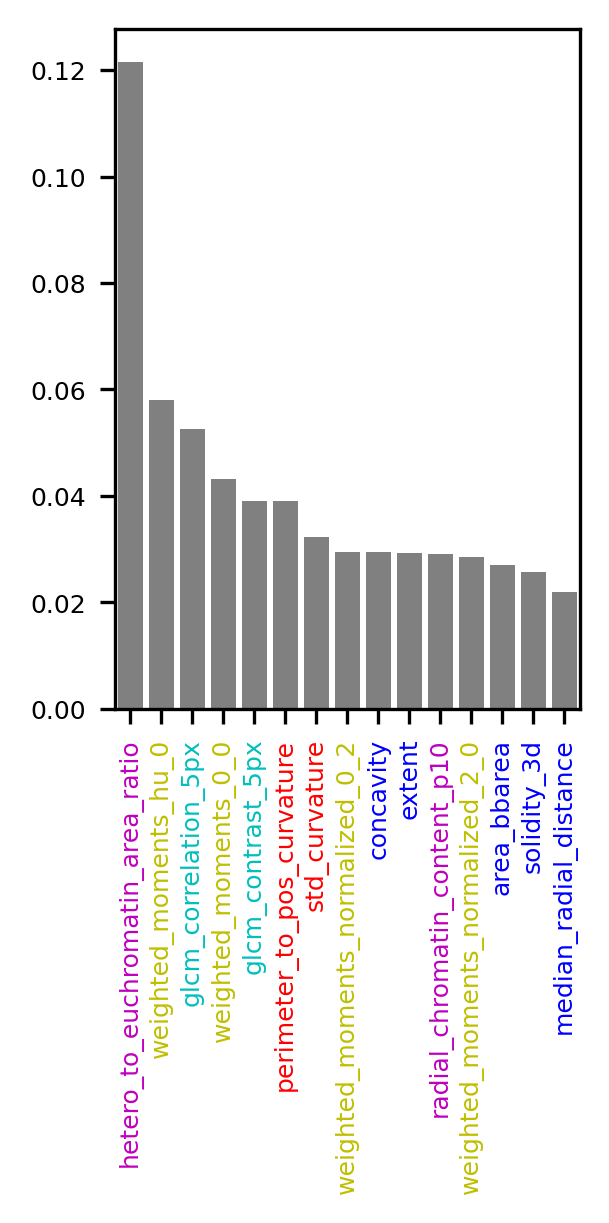

<IPython.core.display.Javascript object>

In [47]:
fig, ax = plot_feature_importance_for_estimator(
    rfc,
    chrometric_data,
    tp_labels,
    scale_features=False,
    feature_color_dict=feature_color_dict,
    n_features=15,
    cmap=["gray"],
    figsize=[2, 3],
)

The analysis suggests that the features that changes the most between the individual treatment populations are associated the shape of the overall DNA intensity distribution inside the nucleus in 2D as well as the overall texture.

The previously shown feature importance plots already suggest a number of candidate chrometric biomarkers that capture the differences of the nuclear phenotypes of the PBMCs during the treatment. We now run marker screen by testing for differential distributions of the individual chrometric features between the different treatment timepoint populations. To this end, we apply a t-test to test for difference in the means and adjust for multiple testing using the Benjamini-Hochberg procedure.

In [34]:
marker_screen_results = find_markers(chrometric_data, tp_labels)

Run marker screen:   0%|          | 0/3 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

#### Prior treatment

At first we look at the features whose mean is significantly different prior the proton therapry treatment compared to during respectively the end of it.

In [35]:
marker_screen_results.loc[marker_screen_results.label == "prior"].head(10)

label                            marker        fc  abs_delta_fc  \
15  prior  hetero_to_euchromatin_area_ratio  1.213320      0.213320   
21  prior              weighted_moments_0_0  0.891398      0.108602   
13  prior        perimeter_to_pos_curvature  0.960882      0.039118   
19  prior              glcm_correlation_5px  0.950645      0.049355   
38  prior             weighted_moments_hu_0  1.138853      0.138853   
45  prior      radial_chromatin_content_p10  0.554790      0.445210   
7   prior                     std_curvature  1.154428      0.154428   
27  prior   weighted_moments_normalized_2_0  1.147136      0.147136   
11  prior       num_prominant_pos_curvature  1.149172      0.149172   
12  prior       num_prominant_neg_curvature  1.184440      0.184440   

             pval    pval_adjust  
15   0.000000e+00   0.000000e+00  
21  5.645906e-228  6.492792e-227  
13  1.062379e-187  1.047202e-186  
19  5.059476e-187  4.363798e-186  
38  1.623135e-183  1.317604e-182  
45  1.617319e-138  1.239945e-137  
7   6.659052e-138  4.836575e-137  
27  8.637253e-110  5.182352e-109  
11  6.077329e-109  3.494464e-108  
12  7.084073e-108  3.910408e-107

<IPython.core.display.Javascript object>

We find that the DNA distribution of the projected nuclei in 2D shows on average a significantly reduced skewness and kurtosis compared to the other two time points. Additionally, we notice that the projected nuclear masks feature a more variable curvature of their boundaries, where as the correlation of the GLCM is signficantly reduced. Finally we observe less condensed chromatin within the inner 10% of the nuclear volume.

---

#### During treatment

Next we look at the features whose mean is significantly different in the during treatment population.

In [36]:
marker_screen_results.loc[marker_screen_results.label == "during"].head(10)

label                            marker        fc  abs_delta_fc  \
15  during  hetero_to_euchromatin_area_ratio  1.086821      0.086821   
38  during             weighted_moments_hu_0  1.062509      0.062509   
21  during              weighted_moments_0_0  0.946631      0.053369   
13  during        perimeter_to_pos_curvature  0.984076      0.015924   
22  during   weighted_moments_normalized_0_2  1.069152      0.069152   
16  during                 glcm_contrast_5px  0.942873      0.057127   
11  during       num_prominant_pos_curvature  1.073017      0.073017   
7   during                     std_curvature  1.059201      0.059201   
12  during       num_prominant_neg_curvature  1.078919      0.078919   
27  during   weighted_moments_normalized_2_0  1.055882      0.055882   

            pval   pval_adjust  
15  4.698033e-96  2.401217e-95  
38  8.114544e-44  3.393355e-43  
21  8.443230e-43  3.426958e-42  
13  6.102642e-32  2.216223e-31  
22  1.548325e-29  5.341722e-29  
16  7.116242e-28  2.338194e-27  
11  9.798298e-28  3.144570e-27  
7   1.432075e-24  4.296226e-24  
12  2.131020e-22  6.257036e-22  
27  8.176327e-20  2.350694e-19

<IPython.core.display.Javascript object>

The during treamtent population seems to feature PBMCs for which the skewness and kurtosis of the DNA distribution of the projected DNA image is reduced. In general the features that are most significantly different are the same one as for the prior timepoint. The direction of change is also similar but yet not as drastic.

---

#### End of treatment

Finally, we also evaluate the chrometric phenotype of PBMCs at the end of the proton therapy treatment.

In [37]:
marker_screen_results.loc[marker_screen_results.label == "end"].head(10)

label                            marker        fc  abs_delta_fc  \
13   end        perimeter_to_pos_curvature  1.056695      0.056695   
15   end  hetero_to_euchromatin_area_ratio  0.740946      0.259054   
7    end                     std_curvature  0.808180      0.191820   
19   end              glcm_correlation_5px  1.063693      0.063693   
21   end              weighted_moments_0_0  1.176863      0.176863   
27   end   weighted_moments_normalized_2_0  0.816798      0.183202   
38   end             weighted_moments_hu_0  0.817833      0.182167   
22   end   weighted_moments_normalized_0_2  0.818867      0.181133   
11   end       num_prominant_pos_curvature  0.800783      0.199217   
12   end       num_prominant_neg_curvature  0.768674      0.231326   

             pval    pval_adjust  
13   0.000000e+00   0.000000e+00  
15   0.000000e+00   0.000000e+00  
7    0.000000e+00   0.000000e+00  
19   0.000000e+00   0.000000e+00  
21   0.000000e+00   0.000000e+00  
27   0.000000e+00   0.000000e+00  
38   0.000000e+00   0.000000e+00  
22   0.000000e+00   0.000000e+00  
11  8.288011e-244  1.143745e-242  
12  9.892097e-231  1.241009e-229

<IPython.core.display.Javascript object>

The PBMCs at the end of the treatment feature DNA distributions that show significantly increased skewness and kurtosis.

---

As a joint proxy to study the alterations in size, we focus at the nuclear volume, the variation in the shape by the concavity of the nucleus and the change in chromatin compaction by the relative heterochromatin to euchromatin ratio, additionally we observe differences in the curvature. Finally, the shape of the DNA intensity distributions of the z-projected nucleus are significantly different. To visualize those differences, we look at the distributions of those markers in the different cancer types.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:7.486e-22 t=-9.641e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:4.823e-81 t=-1.933e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.304e-170 t=-2.868e+01


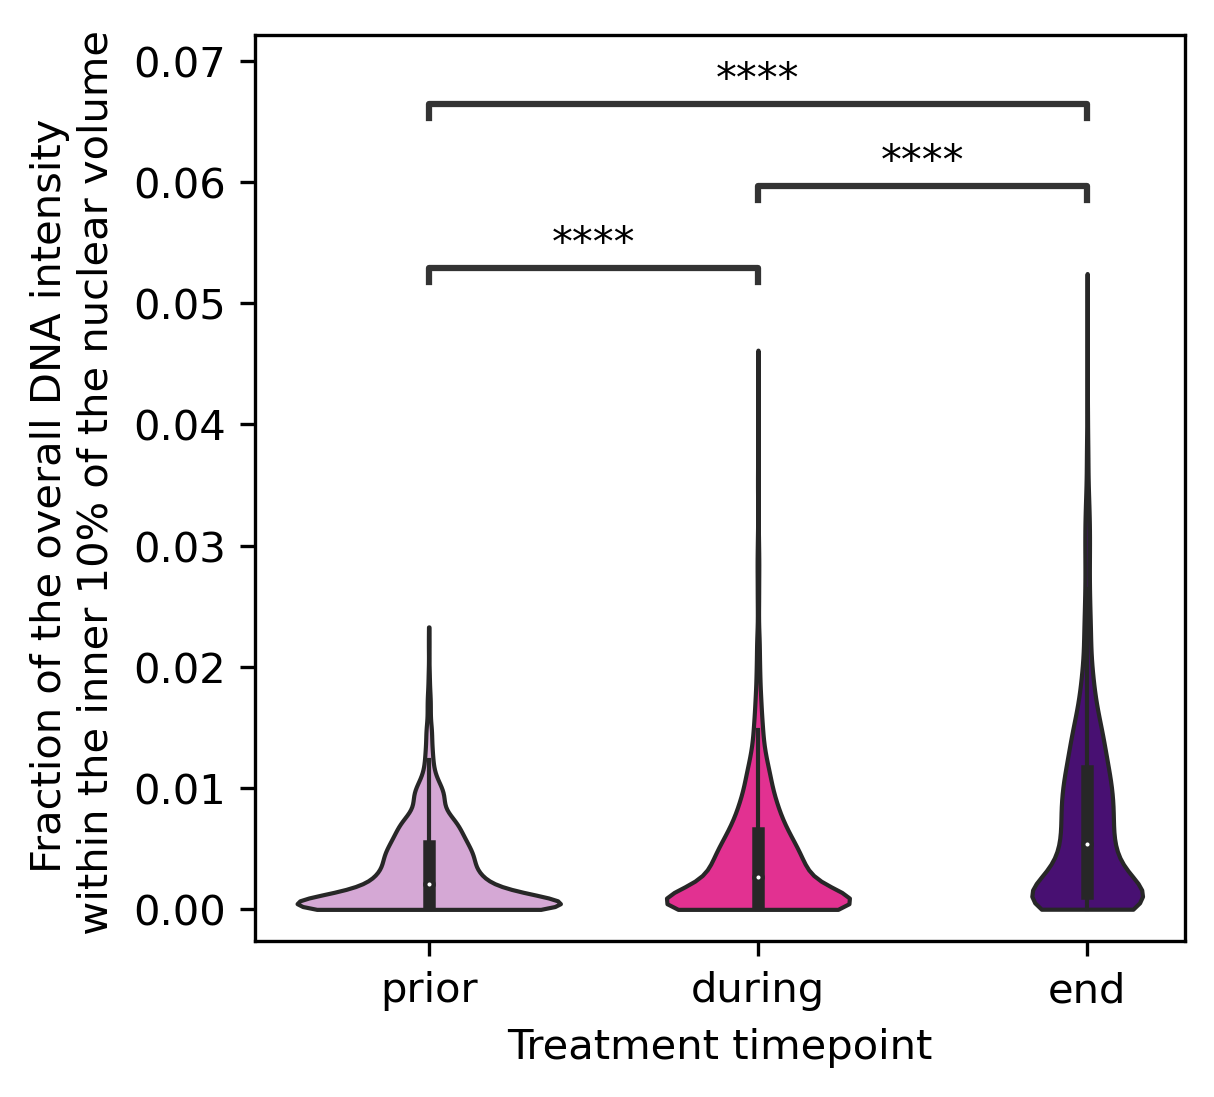

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.061e-18 t=8.855e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.566e-195 t=3.085e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=3.988e+01


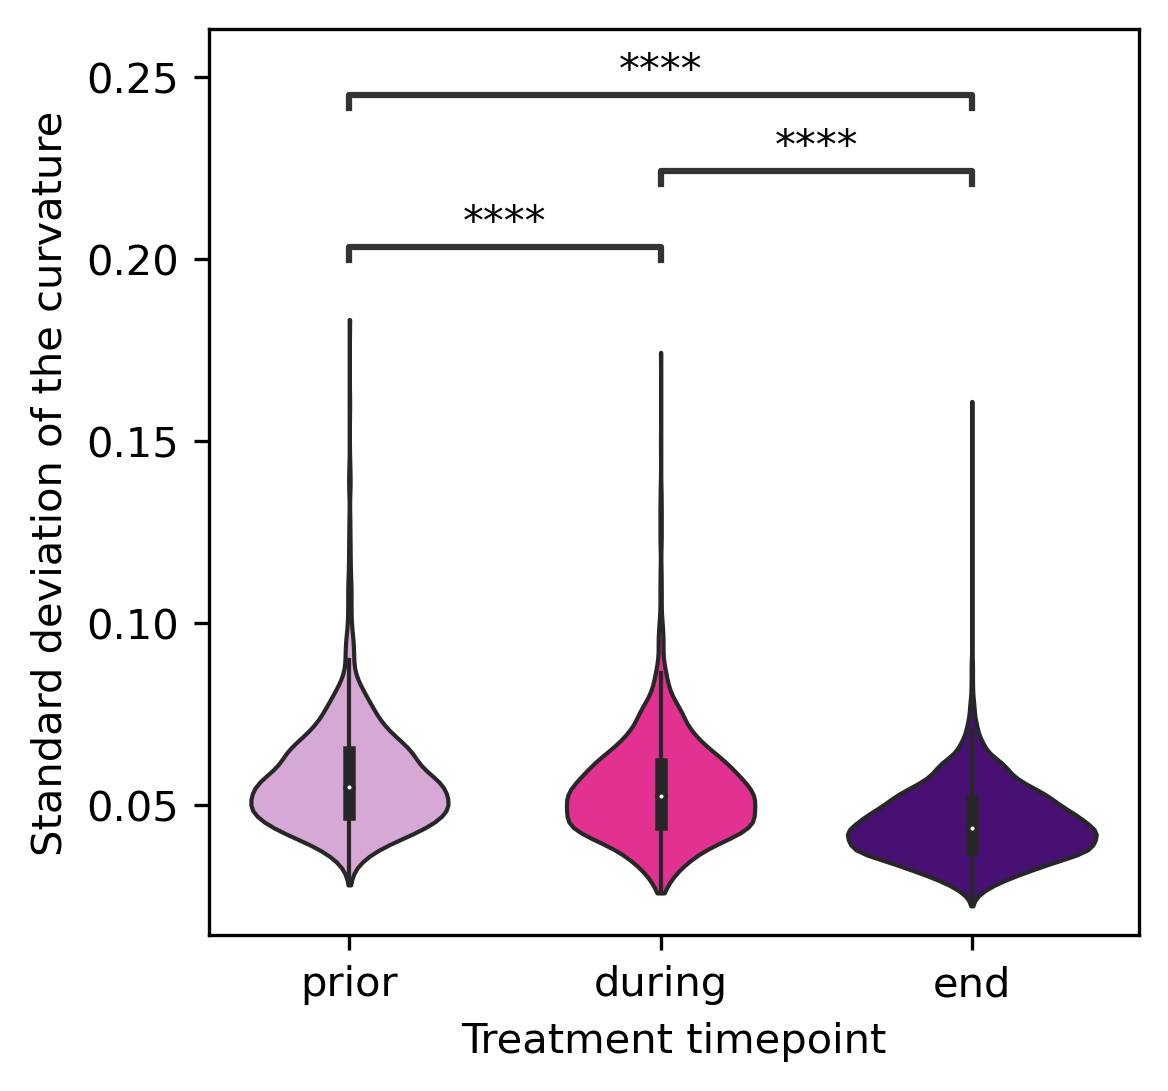

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:2.055e-37 t=-1.286e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.668e-154 t=-2.720e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-4.226e+01


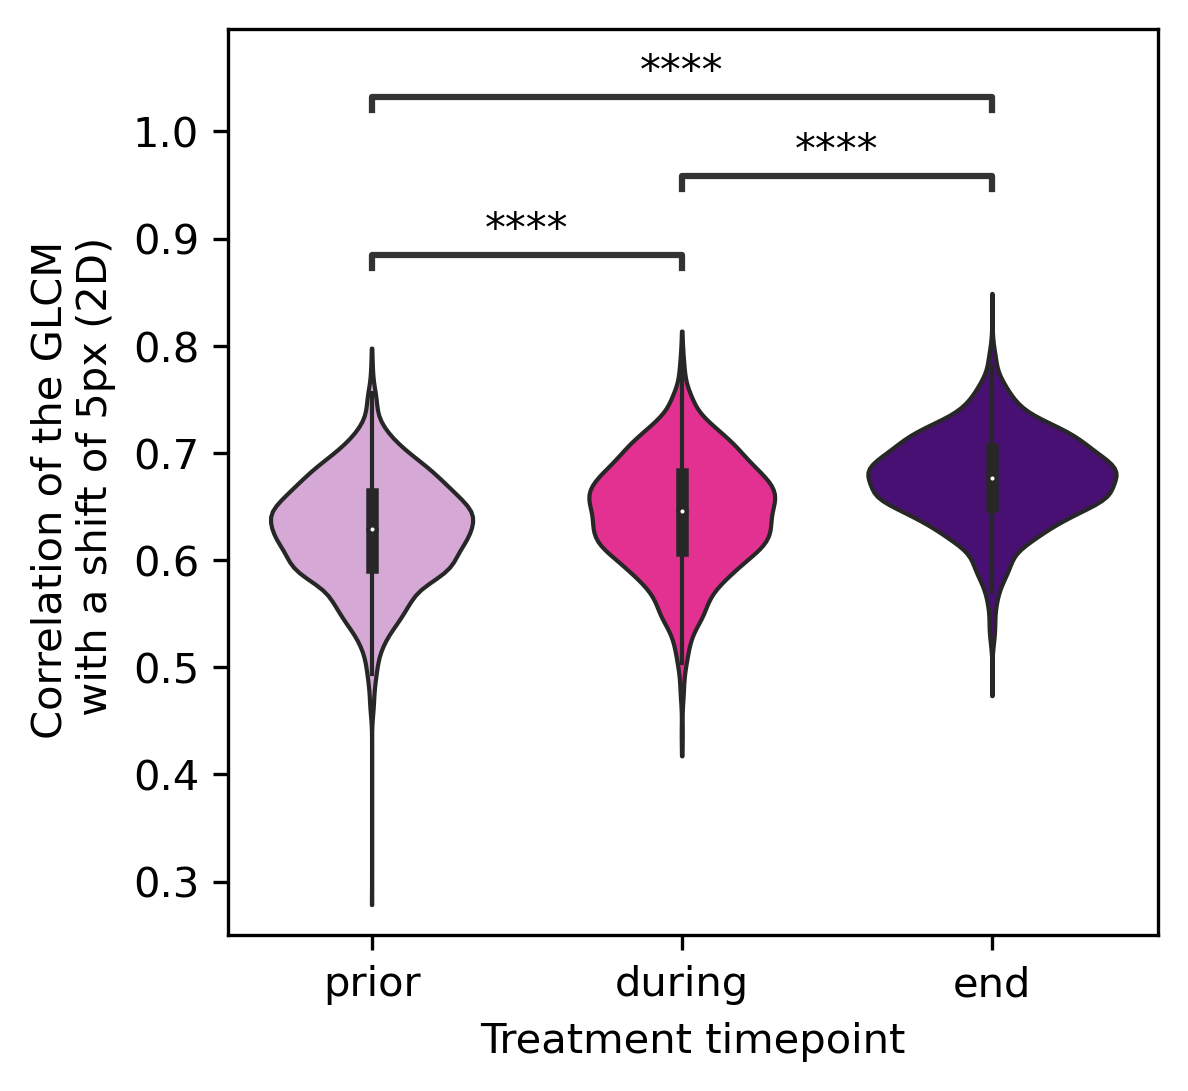

<IPython.core.display.Javascript object>

In [38]:
markers = [
    "radial_chromatin_content_p10",
    "std_curvature",
    "glcm_correlation_5px",
]
marker_labels = [
    "Fraction of the overall DNA intensity \n within the inner 10% of the nuclear volume",
    "Standard deviation of the curvature",
    "Correlation of the GLCM \n with a shift of 5px (2D)",
]
plot_timepoint_markers_dist(
    data, markers, marker_labels, cut=0, palette=color_palette, figsize=[4, 4]
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:7.486e-22 t=-9.641e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:4.823e-81 t=-1.933e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.304e-170 t=-2.868e+01


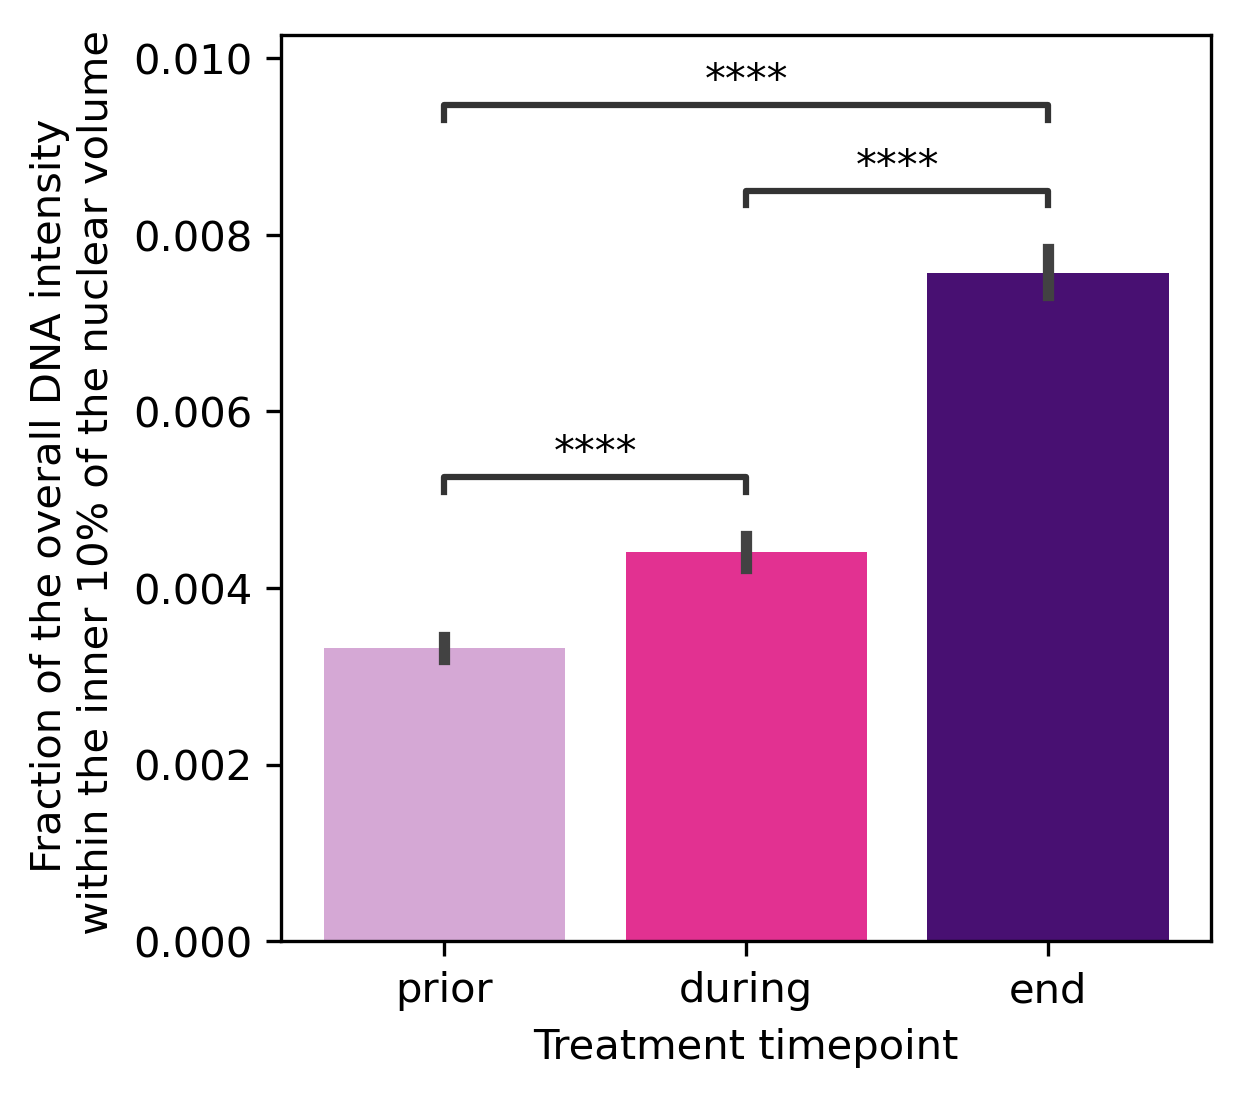

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.061e-18 t=8.855e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.566e-195 t=3.085e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=3.988e+01


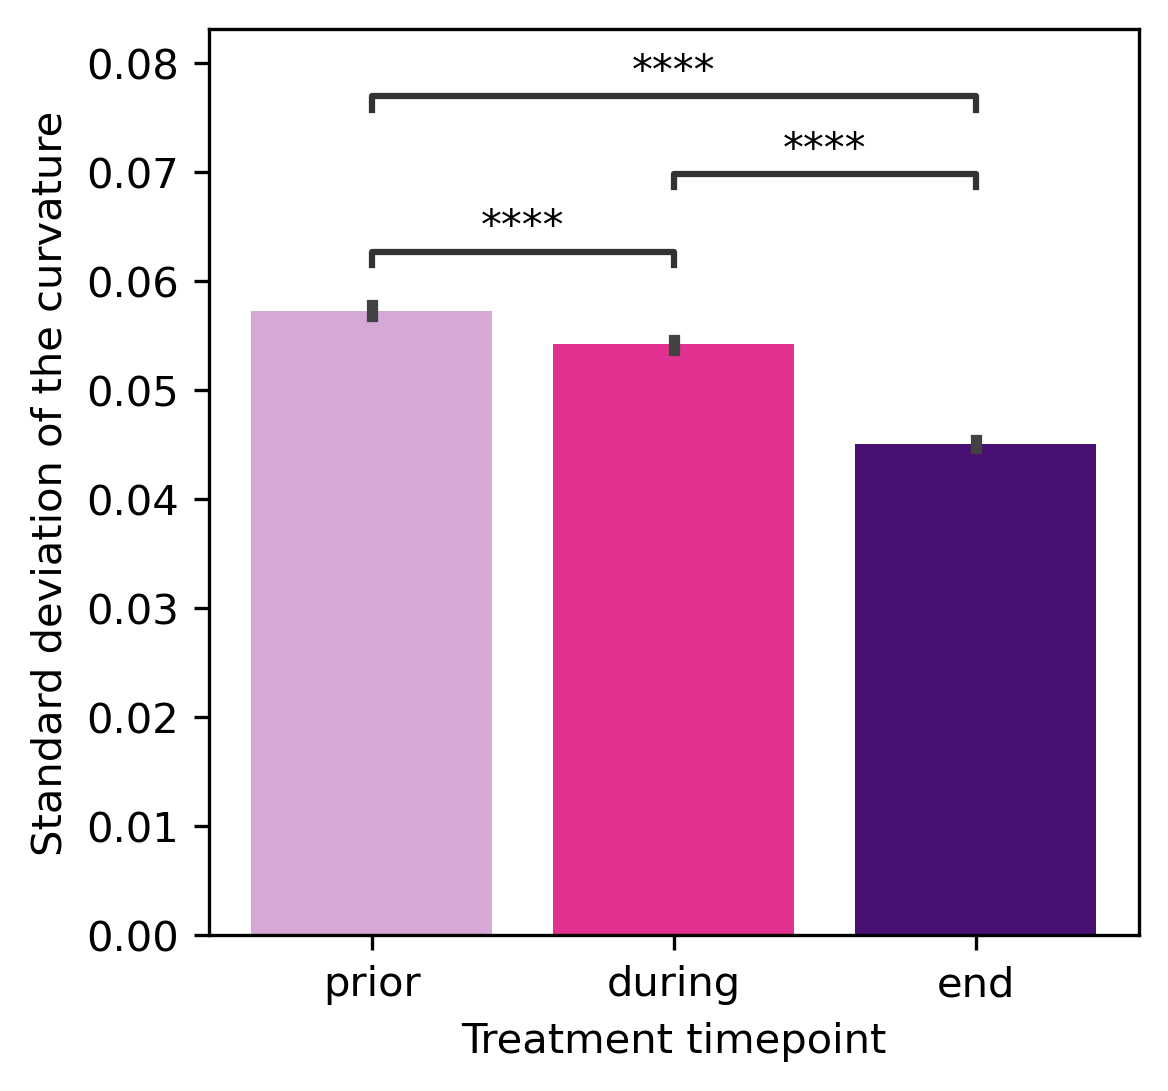

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:2.055e-37 t=-1.286e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.668e-154 t=-2.720e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-4.226e+01


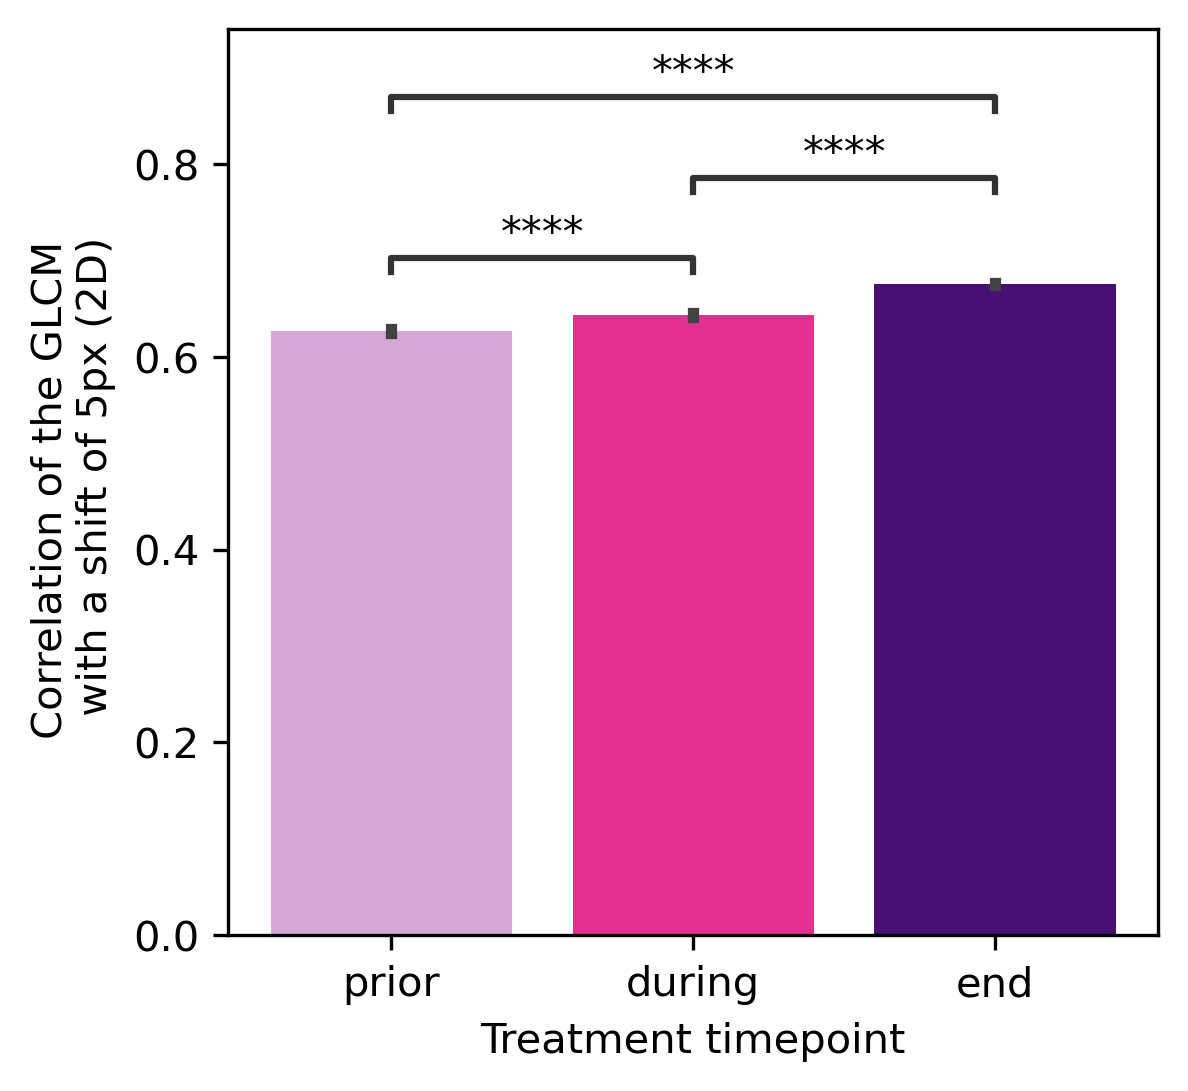

<IPython.core.display.Javascript object>

In [39]:
plot_timepoint_markers_dist(
    data, markers, marker_labels, cut=0, plot_type="bar", palette=color_palette
)

---

### 3d. Proteomic differences of PBMCs in cancer

Finally, we also assess the proteomic differences between the different treatment timepoint populations. To this end, we plot the relative Lamin and gH2AX expression measured by the sum of the intensities of the corresponding imaging channels normalized by the nuclear volume. Additionally, we plot the number of identified gH2AX foci which are computed as the local maxima peaks found in the corresponding channel images.

Note that those features are only available for the first data set that was stained for those proteins.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:5.996e-48 t=-1.467e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:8.628e-66 t=-1.732e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-4.893e+01


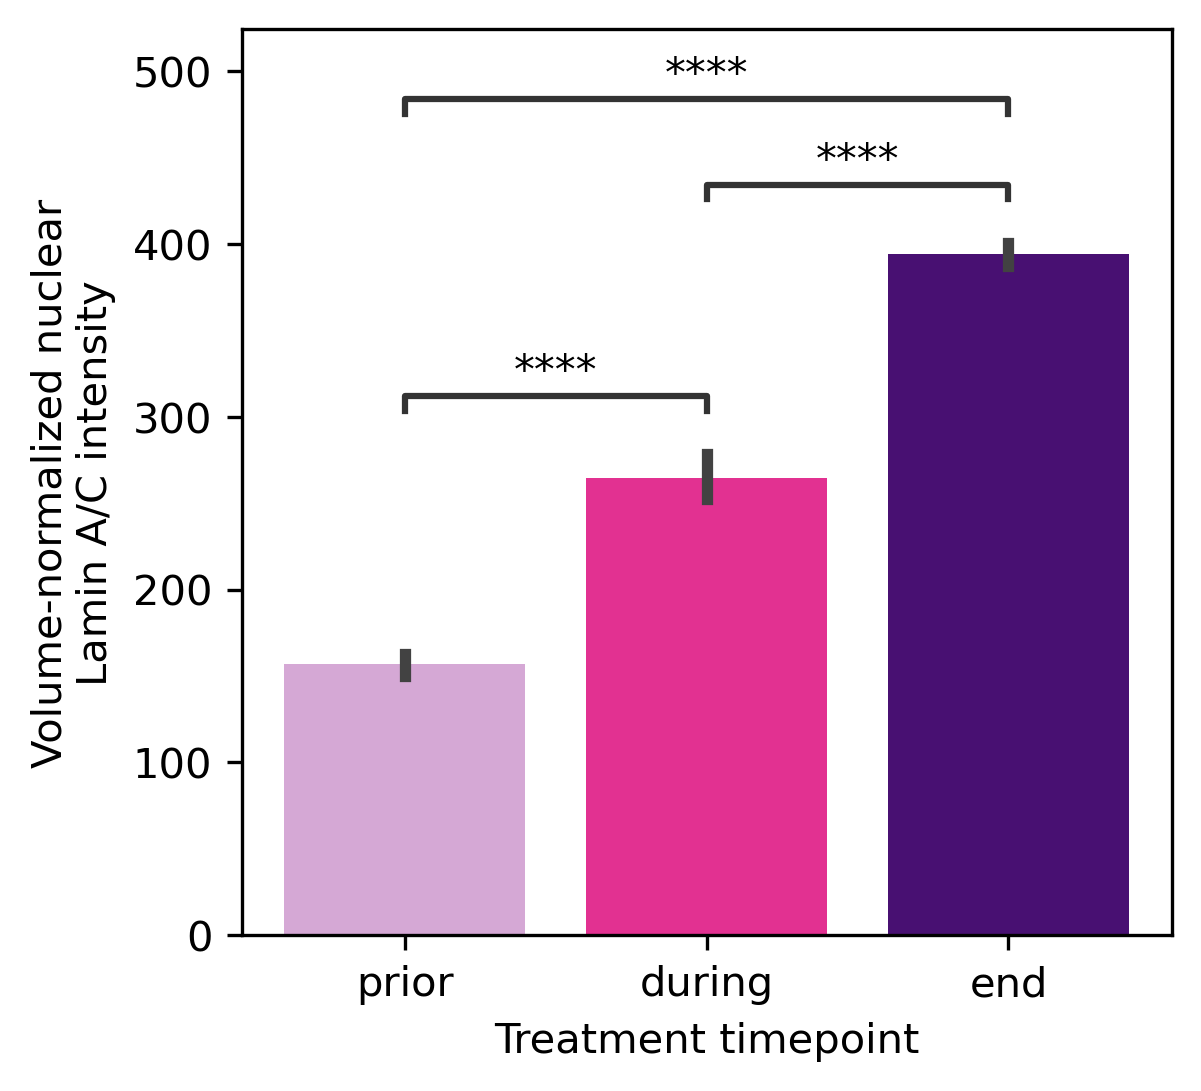

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:5.274e-113 t=-2.304e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-7.931e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-1.197e+02


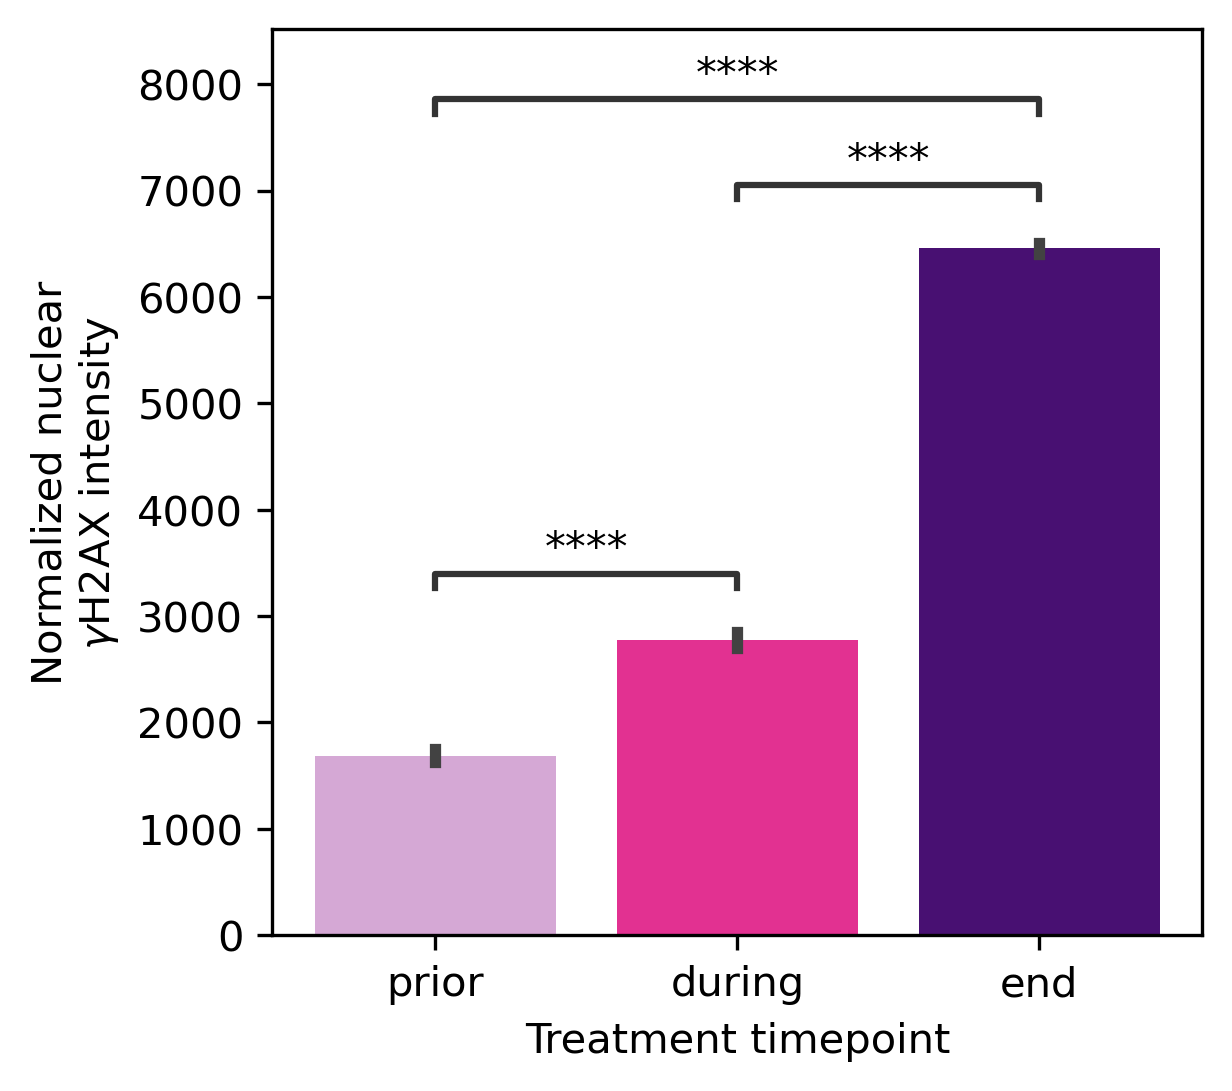

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:4.403e-09 t=5.876e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.288e-215 t=3.253e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.842e-287 t=3.811e+01


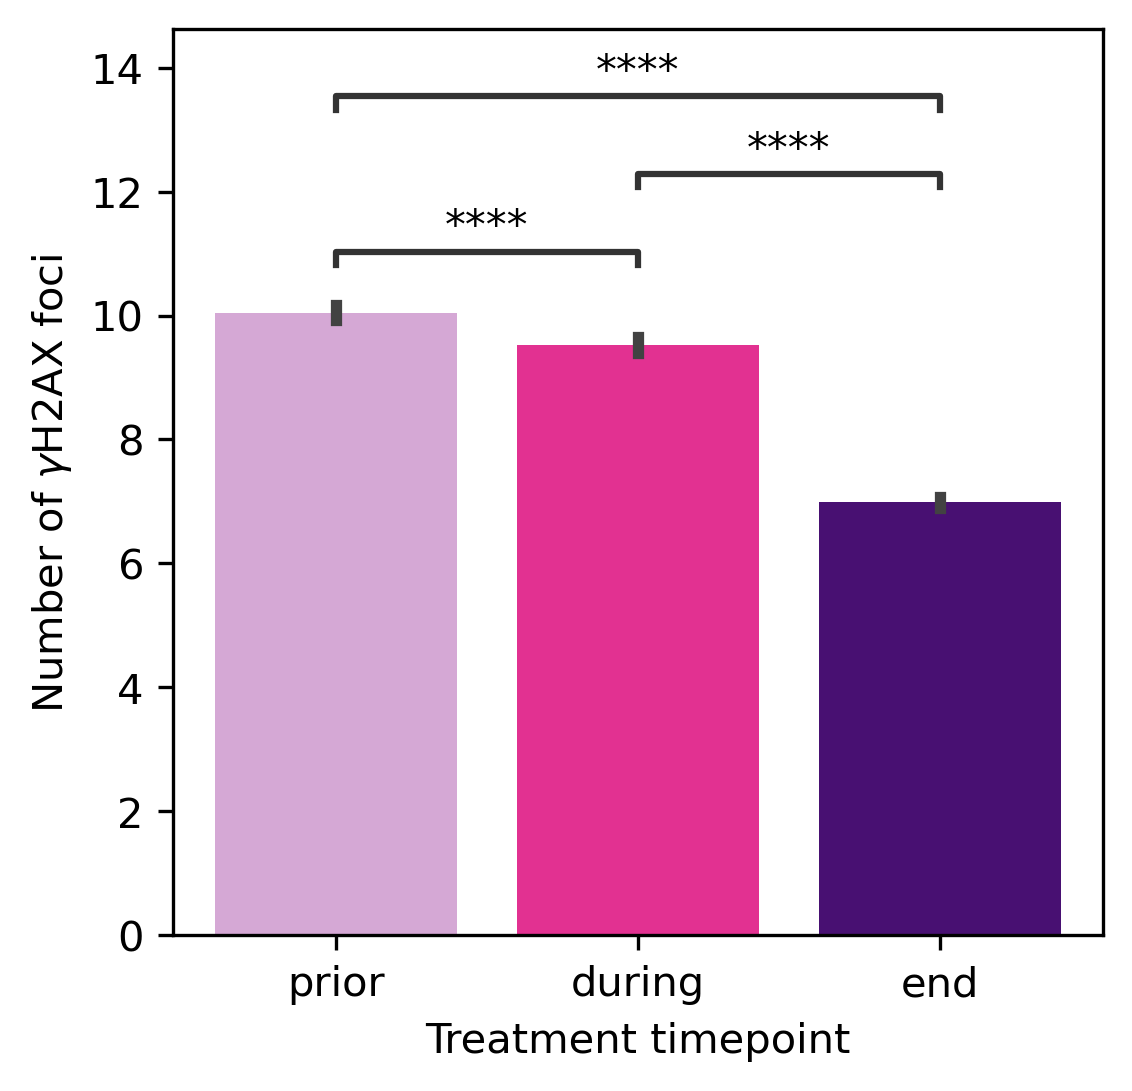

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:4.314e-32 t=1.185e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=4.131e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=5.431e+01


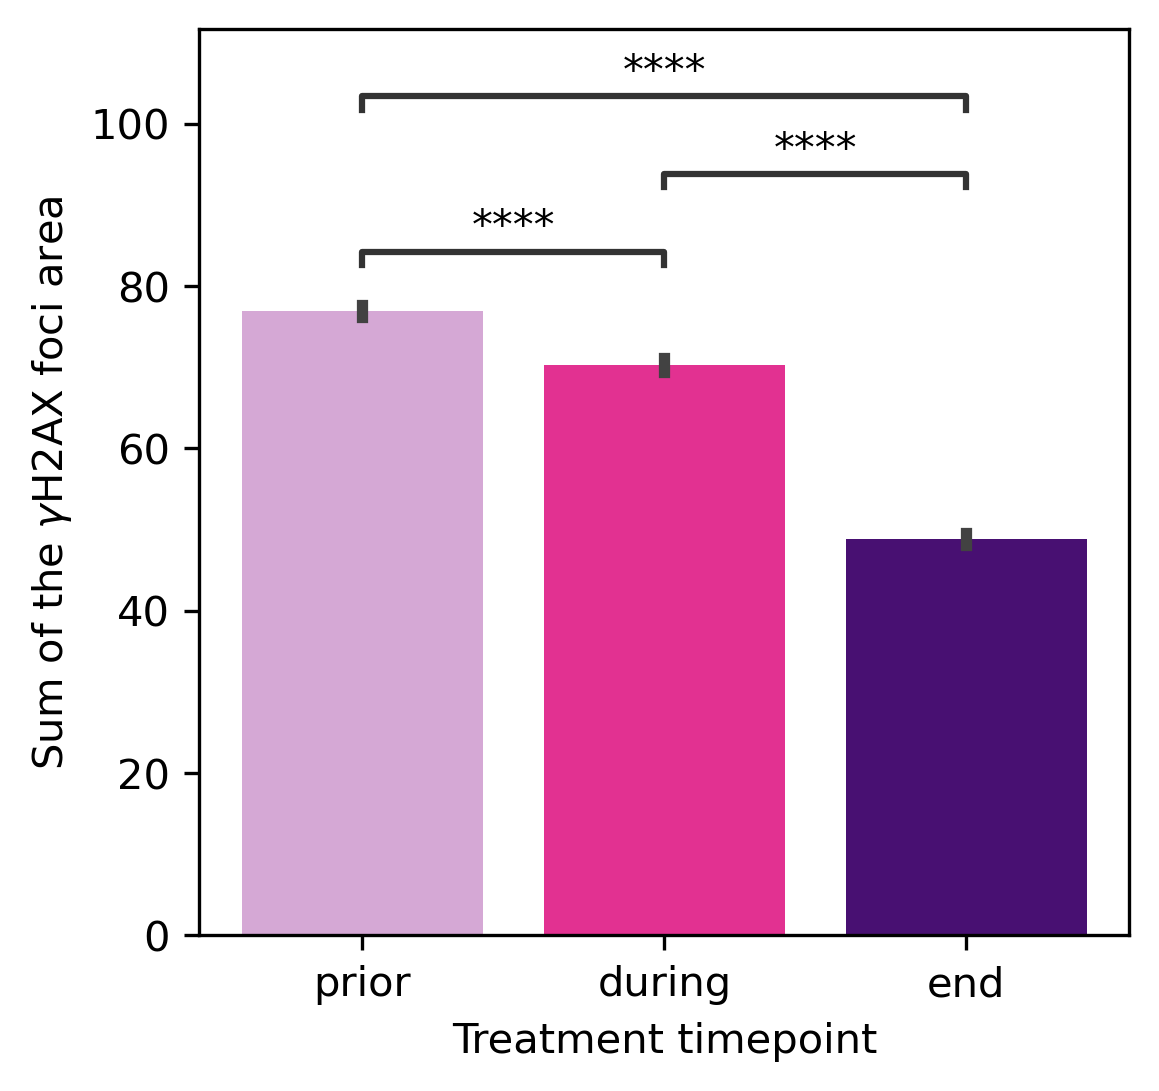

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.188e-06 t=4.862e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:6.974e-16 t=8.091e+00
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:6.692e-47 t=1.450e+01


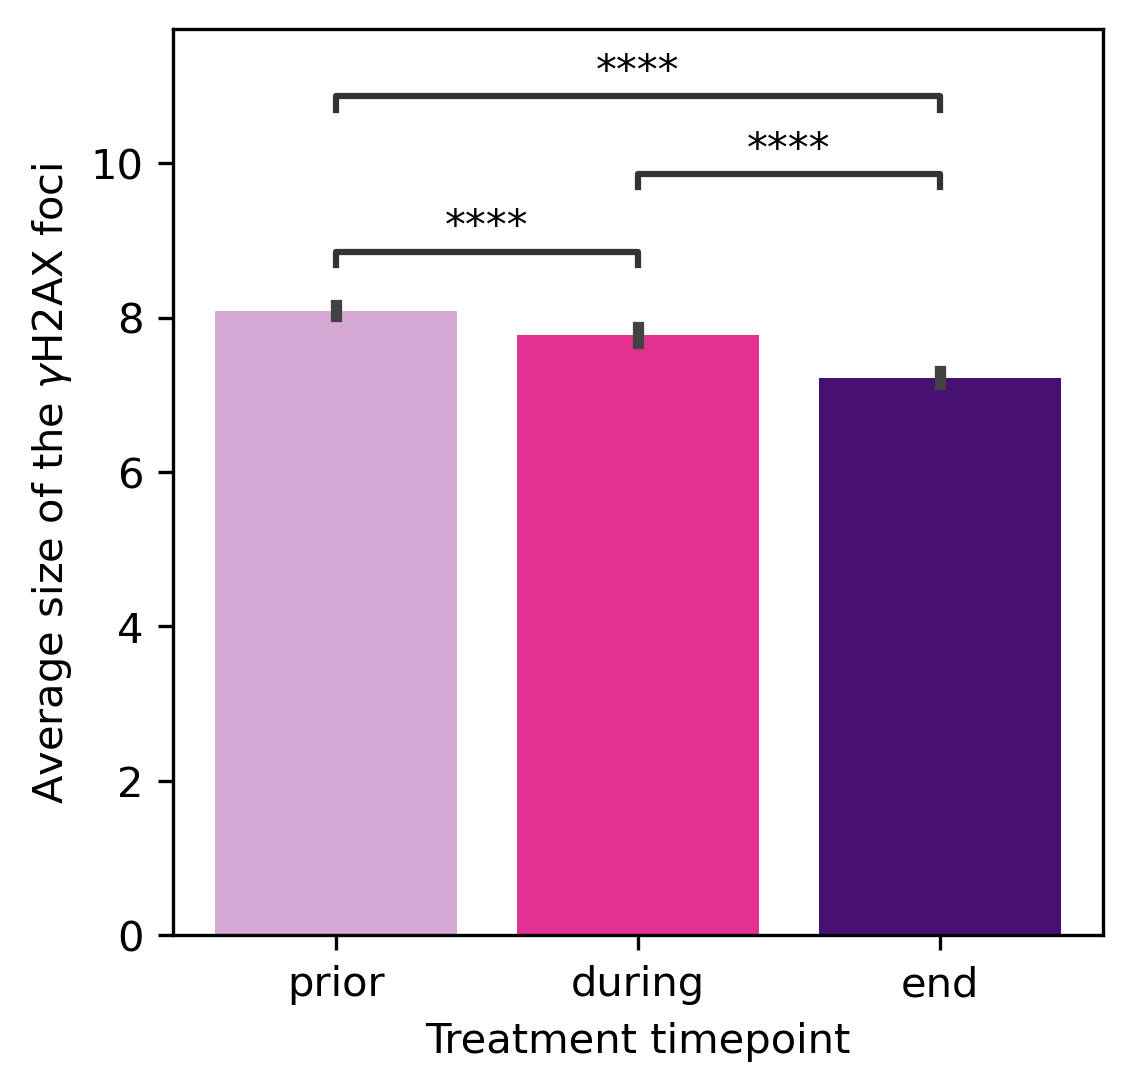

<IPython.core.display.Javascript object>

In [40]:
markers = [
    "rel_lamin_3d_int",
    "rel_gh2ax_3d_int",
    "gh2ax_foci_count",
    "gh2ax_sum_foci_area",
    "gh2ax_avg_foci_area",
]
marker_labels = [
    "Volume-normalized nuclear\nLamin A/C intensity",
    "Normalized nuclear\n" r"$\gamma$H2AX intensity",
    r"Number of $\gamma$H2AX foci",
    r"Sum of the $\gamma$H2AX foci area",
    r"Average size of the $\gamma$H2AX foci",
]
plot_timepoint_markers_dist(
    data,
    markers,
    marker_labels,
    quantiles=None,
    cut=0,
    plot_type="bar",
    palette=color_palette,
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:5.996e-48 t=-1.467e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:8.628e-66 t=-1.732e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-4.893e+01


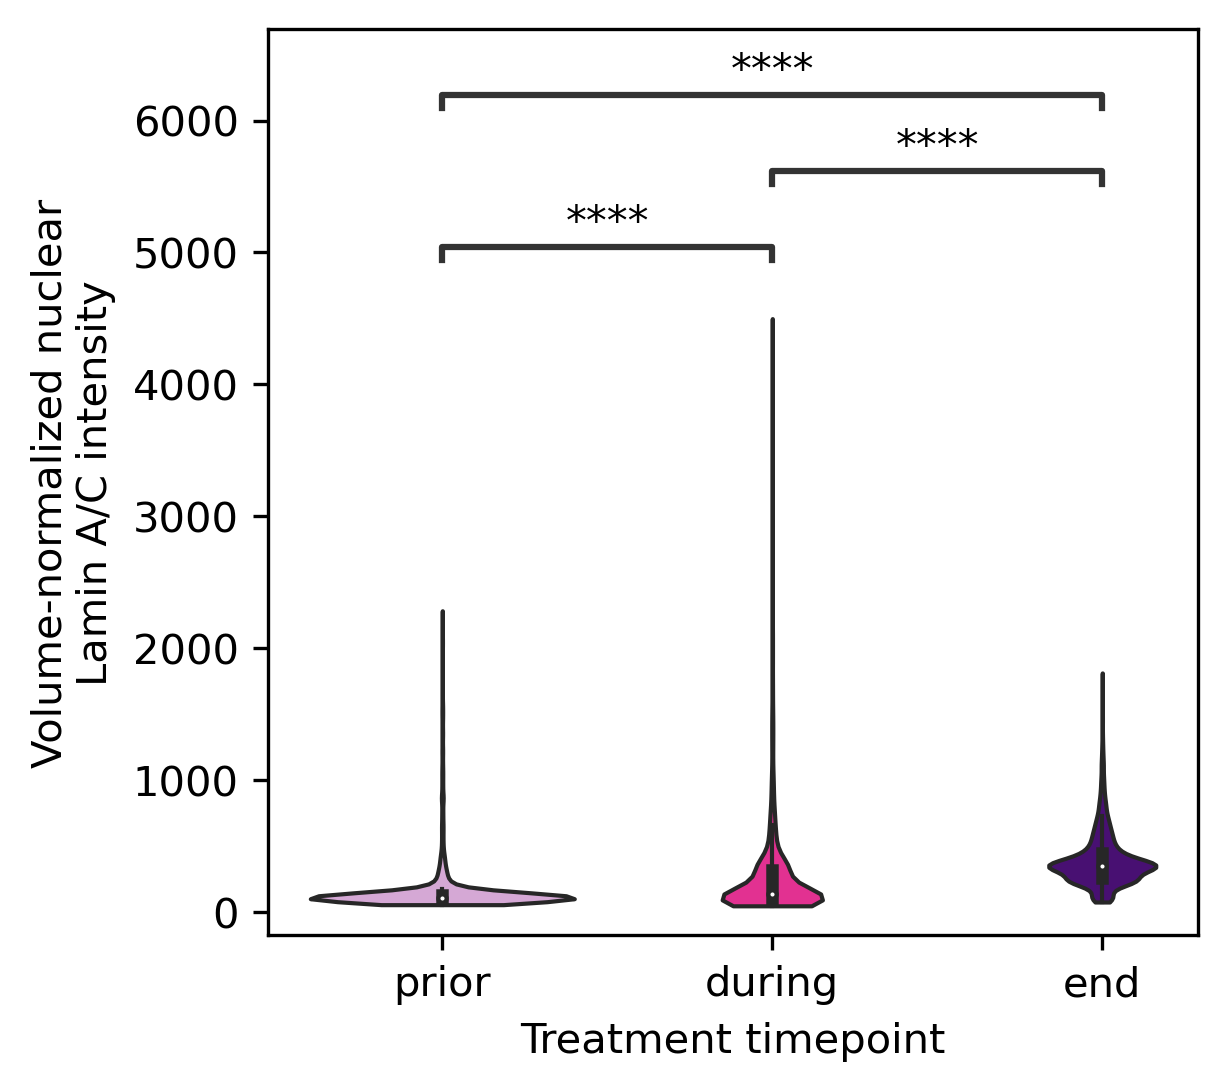

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:5.274e-113 t=-2.304e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-7.931e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-1.197e+02


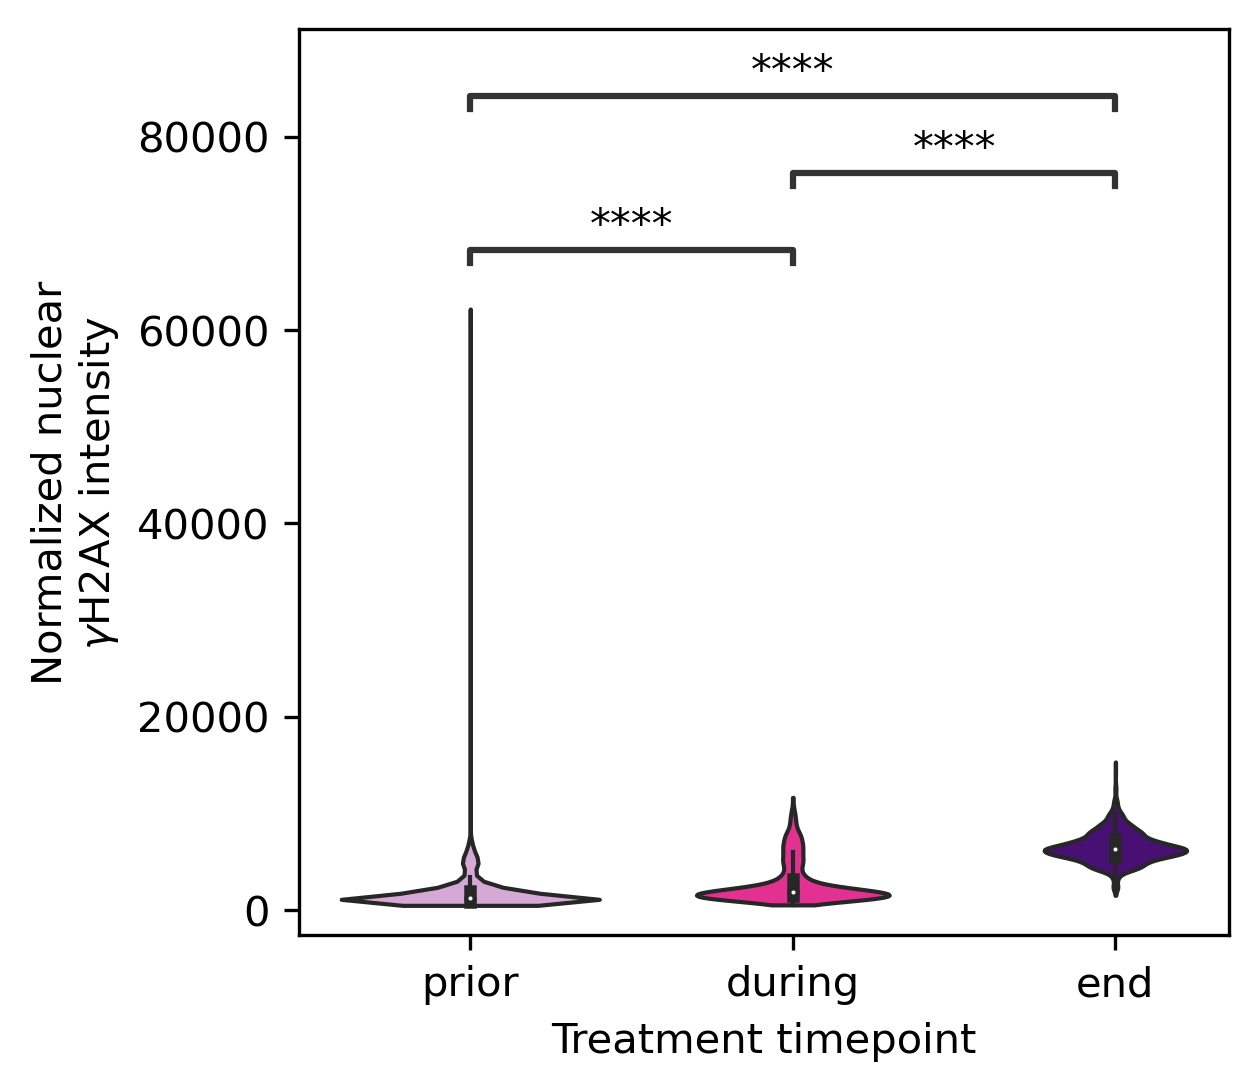

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:4.403e-09 t=5.876e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.288e-215 t=3.253e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:1.842e-287 t=3.811e+01


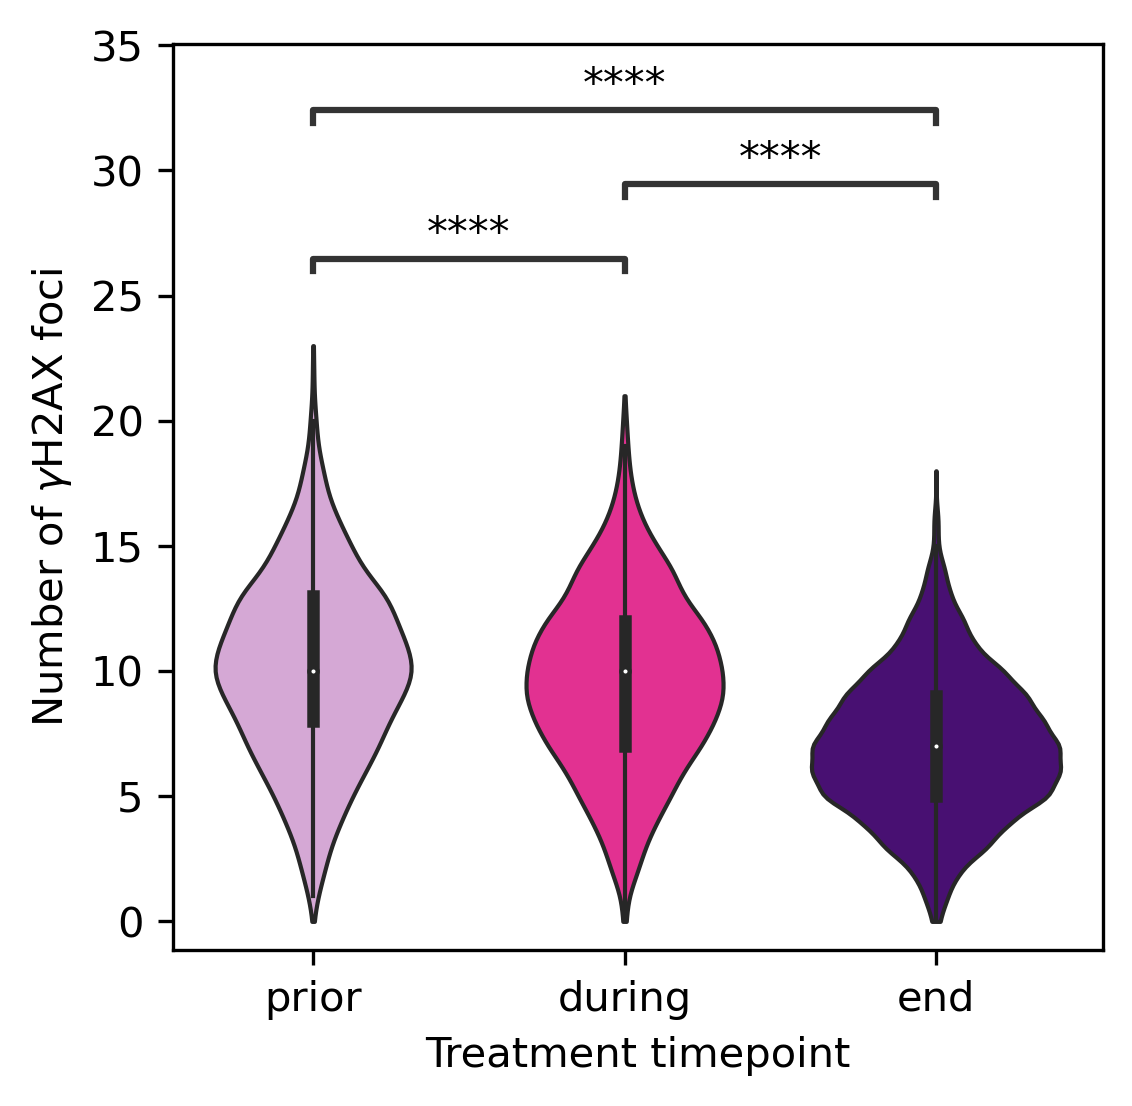

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:4.314e-32 t=1.185e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=4.131e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=5.431e+01


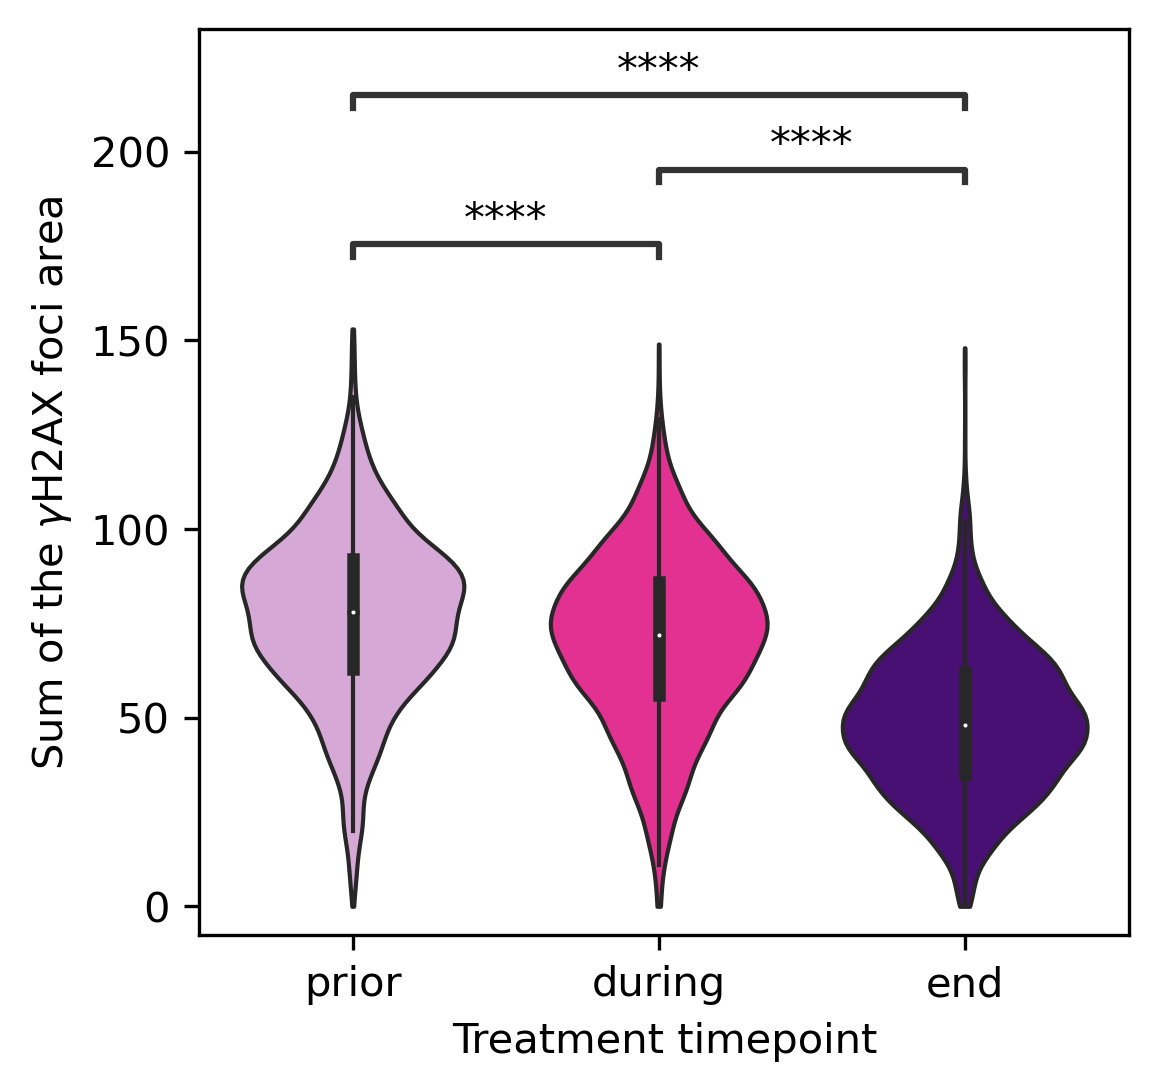

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.188e-06 t=4.862e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:6.974e-16 t=8.091e+00
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:6.692e-47 t=1.450e+01


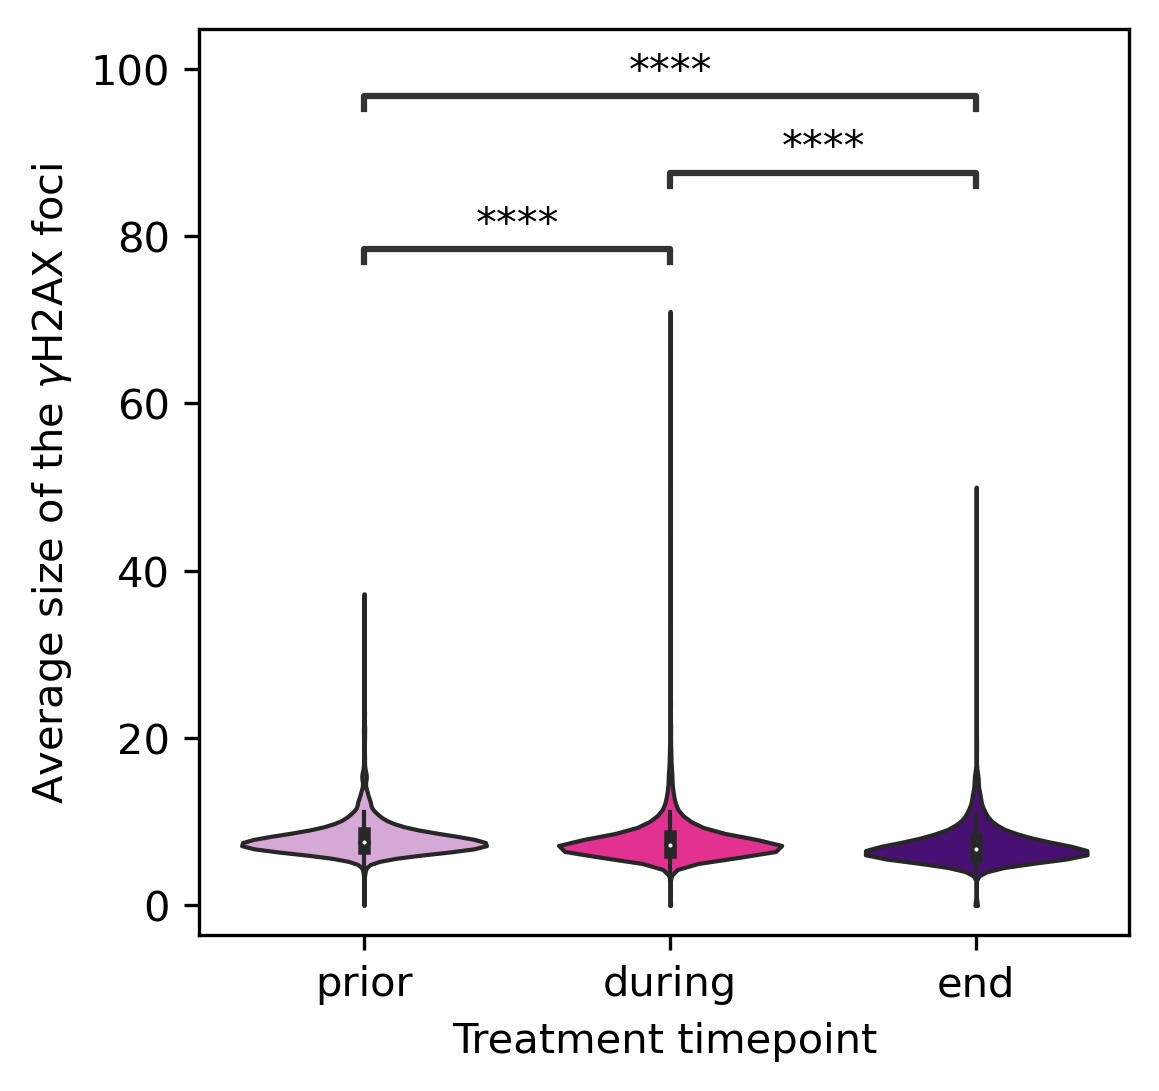

<IPython.core.display.Javascript object>

In [41]:
markers = [
    "rel_lamin_3d_int",
    "rel_gh2ax_3d_int",
    "gh2ax_foci_count",
    "gh2ax_sum_foci_area",
    "gh2ax_avg_foci_area",
]
marker_labels = [
    "Volume-normalized nuclear\nLamin A/C intensity",
    "Normalized nuclear\n" r"$\gamma$H2AX intensity",
    r"Number of $\gamma$H2AX foci",
    r"Sum of the $\gamma$H2AX foci area",
    r"Average size of the $\gamma$H2AX foci",
]
plot_timepoint_markers_dist(
    data,
    markers,
    marker_labels,
    quantiles=None,
    cut=0,
    plot_type="violin",
    palette=color_palette,
)

---

## 4. Supplemental